In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install whois

In [2]:
!pip install pyquery

In [3]:
!pip install interruptingcow

In [1]:
from tqdm import tqdm
from interruptingcow import timeout
import os

In [2]:
import whois
from datetime import datetime, timezone
import math
import pandas as pd
import numpy as np
from pyquery import PyQuery
from requests import get

In [3]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url 
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    ## URL string Features

    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [4]:
path="C:\\Users\\ADI\\Desktop\\Major Project\\Malware_dataset.csv"
malware = pd.read_csv(path) 

In [7]:
#malware.columns =['URL']
#malware.head()

In [5]:
malware.describe()

,http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210
count,11565
unique,2691
top,http://style.org.hc360.com/css/detail/mysite/s...
freq,180


In [9]:
malware.isnull().sum()

http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210    0
dtype: int64

In [6]:
## ONLY FOR MALWARE
malware.drop_duplicates(inplace=True)
malware.nunique()

http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210    2691
dtype: int64

In [7]:
malware.describe()

,http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210
count,2691
unique,2691
top,http://img6.ph.126.net/nV7c6Oh87AtCQhkKu41rgA=...
freq,1


In [8]:
malware.head()

,http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210
0,http://gzzax.livechatvalue.com/chat/chatClient...
3,http://mtsx.com.cn/UploadFiles/2011-08/admin/%...
4,http://mtsx.com.cn/UploadFiles/2011-08/admin/%...
5,http://chinesevie.com/index.php?option=com_mai...
6,http://mtsx.com.cn/UploadFiles/2011-08/admin/%...


In [17]:
malware=malware.reset_index()
malware=malware.drop(['index'], axis=1)
malware.head()

,http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210
0,http://gzzax.livechatvalue.com/chat/chatClient...
1,http://mtsx.com.cn/UploadFiles/2011-08/admin/%...
2,http://mtsx.com.cn/UploadFiles/2011-08/admin/%...
3,http://chinesevie.com/index.php?option=com_mai...
4,http://mtsx.com.cn/UploadFiles/2011-08/admin/%...


In [9]:
type(malware)

pandas.core.frame.DataFrame

In [10]:
type(malware['http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210'])

pandas.core.series.Series

In [11]:
malware.to_csv("Malware_dataset1.csv")

In [4]:
l = ['Malware_dataset1.csv']

In [5]:
emp = UrlFeaturizer("").run().keys()

A = pd.DataFrame(columns = emp)
t=[]
for j in l:
    print(j)
    d=pd.read_csv(j,header=None).to_numpy().flatten()
    for i in tqdm(d):  
        temp=UrlFeaturizer(i).run()
        temp["File"]=j.split(".")[0]
        t.append(temp) 
A=A.append(t)
os.chdir('../')
A.to_csv("Malware_features.csv")

  0%|          | 0/2692 [00:00<?, ?it/s]

Malware_dataset1.csv
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 1/2692 [00:26<20:01:40, 26.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 2/2692 [00:27<8:28:34, 11.34s/it] 

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 3/2692 [00:29<5:18:05,  7.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 4/2692 [00:31<3:48:42,  5.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 5/2692 [00:32<2:46:37,  3.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 6/2692 [00:34<2:21:11,  3.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 7/2692 [00:36<2:04:59,  2.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 8/2692 [01:40<16:37:56, 22.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 9/2692 [02:08<17:56:23, 24.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 10/2692 [02:09<12:32:52, 16.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 11/2692 [02:10<8:49:59, 11.86s/it] 

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 12/2692 [02:10<6:16:46,  8.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  0%|          | 13/2692 [02:11<4:30:18,  6.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 14/2692 [02:11<3:16:40,  4.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 15/2692 [02:12<2:25:12,  3.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 16/2692 [02:14<2:04:08,  2.78s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 17/2692 [02:14<1:35:49,  2.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 19/2692 [02:35<4:28:25,  6.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 20/2692 [02:36<3:32:16,  4.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 21/2692 [03:03<7:53:20, 10.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 22/2692 [03:04<5:51:26,  7.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 23/2692 [03:05<4:20:37,  5.86s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 24/2692 [03:05<3:13:12,  4.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 25/2692 [03:06<2:24:17,  3.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 26/2692 [03:07<1:58:38,  2.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 27/2692 [03:08<1:31:29,  2.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 28/2692 [03:08<1:12:11,  1.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 29/2692 [03:09<1:06:34,  1.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 30/2692 [03:11<1:02:44,  1.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 31/2692 [03:11<52:42,  1.19s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 32/2692 [03:13<1:04:11,  1.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|          | 33/2692 [03:14<54:22,  1.23s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|▏         | 34/2692 [03:15<46:04,  1.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|▏         | 35/2692 [03:17<58:14,  1.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|▏         | 36/2692 [03:17<49:16,  1.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|▏         | 37/2692 [03:18<42:16,  1.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|▏         | 38/2692 [03:18<36:45,  1.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|▏         | 39/2692 [03:19<33:44,  1.31it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  1%|▏         | 40/2692 [03:20<30:32,  1.45it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 41/2692 [03:20<29:33,  1.49it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 42/2692 [03:21<33:35,  1.31it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 43/2692 [03:21<26:12,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 44/2692 [03:22<25:51,  1.71it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 45/2692 [03:24<41:44,  1.06it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 46/2692 [03:24<37:05,  1.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 47/2692 [03:25<34:00,  1.30it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 48/2692 [03:25<27:06,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 49/2692 [03:26<26:18,  1.67it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 50/2692 [03:27<36:13,  1.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 51/2692 [03:28<34:03,  1.29it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 52/2692 [03:28<33:02,  1.33it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 53/2692 [03:30<39:15,  1.12it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 54/2692 [03:30<35:06,  1.25it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 55/2692 [03:51<5:02:19,  6.88s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 56/2692 [04:18<9:20:39, 12.76s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 57/2692 [04:18<6:40:55,  9.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 58/2692 [04:19<4:47:02,  6.54s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 59/2692 [04:19<3:27:26,  4.73s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 61/2692 [04:21<2:09:21,  2.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 62/2692 [04:22<1:43:03,  2.35s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 63/2692 [04:22<1:22:05,  1.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 64/2692 [04:23<1:05:37,  1.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 65/2692 [04:23<55:22,  1.26s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 66/2692 [04:24<46:19,  1.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  2%|▏         | 67/2692 [04:24<39:28,  1.11it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 68/2692 [04:25<36:23,  1.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 69/2692 [04:27<47:03,  1.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 70/2692 [04:27<41:17,  1.06it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 71/2692 [04:48<5:02:40,  6.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 72/2692 [05:15<9:23:21, 12.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 73/2692 [05:17<6:50:28,  9.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 74/2692 [05:24<6:26:19,  8.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 78/2692 [05:27<2:22:58,  3.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 80/2692 [05:27<1:32:17,  2.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 81/2692 [05:28<1:24:06,  1.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 82/2692 [05:30<1:23:50,  1.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 83/2692 [05:32<1:16:16,  1.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 84/2692 [05:32<1:02:29,  1.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 85/2692 [05:33<1:00:14,  1.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 86/2692 [05:36<1:19:23,  1.83s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 87/2692 [05:38<1:23:59,  1.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 88/2692 [05:40<1:13:20,  1.69s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 89/2692 [05:41<1:06:15,  1.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 90/2692 [05:42<1:02:07,  1.43s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 91/2692 [05:42<50:23,  1.16s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 93/2692 [05:43<31:02,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  3%|▎         | 94/2692 [05:44<38:00,  1.14it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▎         | 95/2692 [06:11<6:17:12,  8.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▎         | 96/2692 [06:15<5:13:06,  7.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▎         | 98/2692 [06:15<2:50:54,  3.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▎         | 99/2692 [06:17<2:20:45,  3.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▎         | 100/2692 [06:18<1:57:36,  2.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 101/2692 [06:19<1:39:45,  2.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 102/2692 [06:20<1:26:34,  2.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 103/2692 [06:21<1:06:47,  1.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 104/2692 [06:21<55:19,  1.28s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 105/2692 [06:22<55:30,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 106/2692 [06:24<1:00:06,  1.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 107/2692 [06:25<58:33,  1.36s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 108/2692 [06:26<47:53,  1.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 109/2692 [06:27<40:41,  1.06it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 110/2692 [06:28<44:03,  1.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 111/2692 [06:29<45:17,  1.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 112/2692 [06:30<47:27,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 113/2692 [06:31<44:39,  1.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 114/2692 [06:31<38:07,  1.13it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 115/2692 [06:33<46:59,  1.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 116/2692 [06:34<49:05,  1.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 117/2692 [06:58<5:42:24,  7.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 118/2692 [07:26<9:52:26, 13.81s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 119/2692 [07:27<7:11:57, 10.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 120/2692 [07:27<5:08:07,  7.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  4%|▍         | 121/2692 [07:31<4:20:58,  6.09s/it]

Unknown TLD: .ru&src_url=usd
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

  5%|▍         | 122/2692 [07:32<3:11:01,  4.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 123/2692 [07:33<2:36:09,  3.65s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 124/2692 [07:34<2:01:04,  2.83s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 125/2692 [07:35<1:34:38,  2.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 126/2692 [07:37<1:24:40,  1.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 128/2692 [07:38<56:48,  1.33s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 129/2692 [07:39<48:02,  1.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 130/2692 [07:39<41:15,  1.03it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 132/2692 [07:41<35:17,  1.21it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 133/2692 [07:43<50:53,  1.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▍         | 134/2692 [07:45<54:48,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 135/2692 [07:48<1:28:09,  2.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 137/2692 [07:50<1:05:40,  1.54s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 138/2692 [07:54<1:25:25,  2.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 140/2692 [07:54<51:05,  1.20s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 141/2692 [13:22<65:30:06, 92.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 142/2692 [13:52<52:52:18, 74.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 143/2692 [13:53<37:52:01, 53.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 145/2692 [14:15<21:58:55, 31.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 146/2692 [15:39<33:12:01, 46.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 147/2692 [16:08<29:18:23, 41.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  5%|▌         | 148/2692 [16:09<20:53:12, 29.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 149/2692 [16:10<14:49:18, 20.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 150/2692 [16:11<10:37:06, 15.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 151/2692 [16:32<11:53:24, 16.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 153/2692 [16:33<5:53:41,  8.36s/it] 

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 154/2692 [16:45<6:42:48,  9.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 155/2692 [17:13<10:38:37, 15.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 156/2692 [17:14<7:41:28, 10.92s/it] 

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 157/2692 [17:16<5:40:19,  8.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 158/2692 [17:20<4:57:35,  7.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 159/2692 [17:27<4:52:47,  6.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 160/2692 [17:30<3:59:04,  5.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 161/2692 [17:37<4:18:44,  6.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 162/2692 [17:38<3:16:41,  4.66s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 163/2692 [17:38<2:22:21,  3.38s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 164/2692 [17:39<1:44:29,  2.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 166/2692 [17:40<1:07:18,  1.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 167/2692 [17:41<1:03:05,  1.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▌         | 168/2692 [18:08<5:39:33,  8.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▋         | 169/2692 [18:08<4:13:15,  6.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▋         | 170/2692 [18:09<3:11:37,  4.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▋         | 171/2692 [18:10<2:21:44,  3.37s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▋         | 172/2692 [18:10<1:50:41,  2.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▋         | 173/2692 [18:12<1:38:00,  2.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  6%|▋         | 174/2692 [18:16<1:54:23,  2.73s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 175/2692 [18:17<1:35:29,  2.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 176/2692 [18:18<1:17:24,  1.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 177/2692 [18:19<1:14:00,  1.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 178/2692 [18:20<58:22,  1.39s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 180/2692 [18:20<37:00,  1.13it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 181/2692 [18:21<39:53,  1.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 182/2692 [18:22<34:07,  1.23it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 183/2692 [18:46<5:00:58,  7.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 184/2692 [19:12<8:41:45, 12.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 185/2692 [19:19<7:27:33, 10.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 186/2692 [19:23<6:15:07,  8.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 188/2692 [19:24<3:13:53,  4.65s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 189/2692 [19:27<2:49:28,  4.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 190/2692 [19:29<2:31:11,  3.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 191/2692 [19:33<2:31:47,  3.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 192/2692 [19:35<2:08:07,  3.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 193/2692 [19:36<1:45:59,  2.54s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 194/2692 [19:42<2:27:55,  3.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 195/2692 [19:46<2:33:28,  3.69s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 196/2692 [20:17<8:17:31, 11.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 197/2692 [20:22<6:42:25,  9.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 198/2692 [20:27<5:50:14,  8.43s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 199/2692 [20:32<4:59:43,  7.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 200/2692 [20:38<4:44:40,  6.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  7%|▋         | 201/2692 [20:45<4:57:35,  7.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 202/2692 [21:16<9:48:48, 14.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 203/2692 [21:23<8:23:17, 12.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 204/2692 [21:26<6:28:57,  9.38s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 205/2692 [21:27<4:44:00,  6.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 207/2692 [21:28<2:26:06,  3.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 208/2692 [21:28<1:44:05,  2.51s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 209/2692 [21:29<1:22:19,  1.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 210/2692 [21:30<1:05:14,  1.58s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 211/2692 [21:30<53:04,  1.28s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 213/2692 [21:32<38:31,  1.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 214/2692 [21:36<1:21:32,  1.97s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 215/2692 [21:40<1:49:11,  2.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 218/2692 [21:42<1:02:02,  1.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 219/2692 [22:10<4:53:18,  7.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 220/2692 [22:15<4:32:40,  6.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 221/2692 [22:20<4:14:43,  6.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 222/2692 [22:24<3:57:33,  5.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 223/2692 [22:30<3:56:18,  5.74s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 224/2692 [22:35<3:47:52,  5.54s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 225/2692 [22:40<3:34:16,  5.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 226/2692 [23:08<8:16:02, 12.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 227/2692 [23:11<6:22:49,  9.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  8%|▊         | 228/2692 [23:12<4:41:30,  6.86s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▊         | 229/2692 [23:14<3:35:40,  5.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▊         | 230/2692 [23:14<2:36:51,  3.82s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▊         | 231/2692 [23:15<2:02:32,  2.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▊         | 233/2692 [23:16<1:18:43,  1.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▊         | 234/2692 [23:19<1:29:50,  2.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▊         | 235/2692 [23:21<1:21:41,  1.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 236/2692 [23:22<1:09:33,  1.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 237/2692 [23:23<1:03:26,  1.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 238/2692 [23:24<59:22,  1.45s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 239/2692 [23:25<52:52,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 240/2692 [23:26<48:40,  1.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 241/2692 [23:26<39:11,  1.04it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 242/2692 [23:31<1:22:30,  2.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 243/2692 [23:31<1:00:24,  1.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 244/2692 [23:34<1:12:33,  1.78s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 245/2692 [23:36<1:18:53,  1.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 246/2692 [24:23<10:28:19, 15.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 247/2692 [24:23<7:28:02, 10.99s/it] 

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 248/2692 [24:25<5:29:34,  8.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 249/2692 [24:26<4:04:34,  6.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 250/2692 [24:28<3:19:41,  4.91s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 251/2692 [24:29<2:34:20,  3.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 252/2692 [24:31<2:03:39,  3.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 253/2692 [24:32<1:40:38,  2.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 254/2692 [24:58<6:34:21,  9.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


  9%|▉         | 255/2692 [24:59<4:48:09,  7.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 256/2692 [25:01<3:35:49,  5.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 257/2692 [25:01<2:38:06,  3.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 258/2692 [25:02<1:58:20,  2.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 259/2692 [25:02<1:28:09,  2.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 260/2692 [25:13<3:16:38,  4.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 261/2692 [25:14<2:28:45,  3.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 262/2692 [25:15<1:54:54,  2.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 263/2692 [25:16<1:28:51,  2.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 265/2692 [25:17<55:24,  1.37s/it]  

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 267/2692 [25:17<31:54,  1.27it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 268/2692 [25:18<30:01,  1.35it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|▉         | 269/2692 [25:19<35:29,  1.14it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 270/2692 [25:41<4:18:51,  6.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 271/2692 [26:07<8:02:17, 11.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 273/2692 [26:08<4:39:34,  6.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 274/2692 [26:10<3:55:23,  5.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 275/2692 [26:11<2:59:21,  4.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 276/2692 [26:13<2:33:24,  3.81s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 10%|█         | 280/2692 [26:14<1:04:54,  1.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 281/2692 [26:14<58:19,  1.45s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 10%|█         | 282/2692 [26:15<51:26,  1.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 283/2692 [26:16<50:51,  1.27s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 284/2692 [26:18<51:32,  1.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 286/2692 [26:19<40:34,  1.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 291/2692 [26:20<17:24,  2.30it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 292/2692 [26:20<18:16,  2.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 293/2692 [26:21<19:02,  2.10it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 294/2692 [26:22<22:25,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 295/2692 [26:23<24:38,  1.62it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 296/2692 [26:23<25:48,  1.55it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 297/2692 [26:24<29:29,  1.35it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 298/2692 [26:25<29:39,  1.35it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 299/2692 [26:26<29:11,  1.37it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 300/2692 [26:27<37:33,  1.06it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 301/2692 [26:29<40:51,  1.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█         | 302/2692 [26:30<44:28,  1.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█▏        | 303/2692 [26:31<45:04,  1.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█▏        | 304/2692 [26:32<40:41,  1.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█▏        | 305/2692 [26:33<37:41,  1.06it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█▏        | 306/2692 [26:33<34:44,  1.14it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█▏        | 307/2692 [26:34<36:28,  1.09it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█▏        | 308/2692 [26:35<34:52,  1.14it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 11%|█▏        | 309/2692 [26:36<33:24,  1.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 310/2692 [26:37<38:56,  1.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 311/2692 [27:04<5:49:12,  8.80s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 312/2692 [27:05<4:15:56,  6.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 313/2692 [27:06<3:06:38,  4.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 314/2692 [27:06<2:18:05,  3.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 315/2692 [27:07<1:43:20,  2.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 316/2692 [27:08<1:19:43,  2.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 317/2692 [27:08<1:03:58,  1.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 318/2692 [27:09<51:59,  1.31s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 319/2692 [27:10<44:36,  1.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 320/2692 [27:10<38:01,  1.04it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 321/2692 [27:11<33:40,  1.17it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 322/2692 [27:11<30:13,  1.31it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 323/2692 [27:12<28:13,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 324/2692 [27:13<27:05,  1.46it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 325/2692 [27:13<25:36,  1.54it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 326/2692 [27:14<24:48,  1.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 327/2692 [27:14<24:29,  1.61it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 328/2692 [27:15<23:40,  1.66it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 329/2692 [27:15<23:11,  1.70it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 330/2692 [27:16<22:48,  1.73it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 331/2692 [27:17<22:58,  1.71it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 332/2692 [27:17<23:09,  1.70it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 333/2692 [27:18<23:34,  1.67it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 334/2692 [27:19<27:45,  1.42it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 335/2692 [27:19<26:42,  1.47it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 12%|█▏        | 336/2692 [27:20<26:05,  1.51it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 337/2692 [27:21<25:46,  1.52it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 338/2692 [27:21<25:20,  1.55it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 339/2692 [27:22<24:55,  1.57it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 340/2692 [27:22<23:59,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 341/2692 [27:23<24:01,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 342/2692 [27:24<23:31,  1.67it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 343/2692 [27:24<23:12,  1.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 344/2692 [27:25<23:04,  1.70it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 345/2692 [27:25<23:15,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 346/2692 [27:26<23:26,  1.67it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 347/2692 [27:27<23:40,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 348/2692 [27:27<23:12,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 349/2692 [27:28<23:39,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 350/2692 [27:28<24:04,  1.62it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 351/2692 [27:29<24:33,  1.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 352/2692 [27:30<24:30,  1.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 353/2692 [27:30<24:26,  1.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 354/2692 [27:31<24:13,  1.61it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 355/2692 [27:32<23:32,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 356/2692 [27:35<57:24,  1.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 357/2692 [28:02<5:54:15,  9.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 358/2692 [28:03<4:14:50,  6.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 359/2692 [28:03<3:05:30,  4.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 360/2692 [28:04<2:17:15,  3.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 361/2692 [28:04<1:42:59,  2.65s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 362/2692 [28:05<1:19:00,  2.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 13%|█▎        | 363/2692 [28:06<1:01:44,  1.59s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▎        | 364/2692 [28:06<50:14,  1.30s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▎        | 365/2692 [28:07<42:14,  1.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▎        | 366/2692 [28:07<36:20,  1.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▎        | 367/2692 [28:08<32:40,  1.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▎        | 368/2692 [28:09<30:22,  1.28it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▎        | 369/2692 [28:09<28:19,  1.37it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▎        | 370/2692 [28:10<26:39,  1.45it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 371/2692 [28:10<25:58,  1.49it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 372/2692 [28:11<25:00,  1.55it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 373/2692 [28:12<24:27,  1.58it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 374/2692 [28:12<24:24,  1.58it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 375/2692 [28:13<23:30,  1.64it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 376/2692 [28:13<22:58,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 377/2692 [28:14<23:12,  1.66it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 378/2692 [28:15<23:22,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 379/2692 [28:15<24:54,  1.55it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 380/2692 [28:16<24:28,  1.57it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 381/2692 [28:17<23:33,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 382/2692 [28:17<27:27,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 383/2692 [28:18<26:02,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 384/2692 [28:19<25:50,  1.49it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 385/2692 [28:20<29:01,  1.32it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 386/2692 [28:20<27:29,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 387/2692 [28:21<25:38,  1.50it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 388/2692 [28:21<24:23,  1.57it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 389/2692 [28:22<23:30,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 14%|█▍        | 390/2692 [28:23<22:55,  1.67it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▍        | 391/2692 [28:23<22:43,  1.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▍        | 392/2692 [28:24<22:20,  1.72it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▍        | 393/2692 [28:24<21:46,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▍        | 394/2692 [28:25<21:24,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▍        | 395/2692 [28:25<21:18,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▍        | 400/2692 [28:29<19:38,  1.95it/s]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading depe

 15%|█▍        | 403/2692 [28:30<16:04,  2.37it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▌        | 404/2692 [28:30<17:24,  2.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▌        | 405/2692 [28:31<17:16,  2.21it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▌        | 406/2692 [28:31<16:51,  2.26it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▌        | 407/2692 [28:33<31:00,  1.23it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▌        | 412/2692 [28:59<1:56:05,  3.06s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 15%|█▌        | 414/2692 [29:00<1:26:58,  2.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 15%|█▌        | 416/2692 [29:04<1:18:12,  2.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 418/2692 [29:16<1:57:28,  3.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 419/2692 [29:18<1:49:51,  2.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 420/2692 [29:18<1:27:04,  2.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 421/2692 [29:20<1:22:11,  2.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 422/2692 [29:22<1:21:42,  2.16s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 423/2692 [29:24<1:13:47,  1.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 424/2692 [29:25<1:03:03,  1.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 425/2692 [29:25<52:27,  1.39s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 426/2692 [29:27<58:35,  1.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 427/2692 [29:29<1:01:57,  1.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 428/2692 [30:16<9:29:18, 15.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 429/2692 [30:17<6:42:51, 10.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 430/2692 [30:18<4:53:44,  7.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 434/2692 [30:18<1:52:05,  2.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 435/2692 [30:19<1:35:17,  2.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 436/2692 [30:19<1:19:57,  2.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▌        | 437/2692 [30:20<1:06:14,  1.76s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▋        | 438/2692 [30:20<54:57,  1.46s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▋        | 439/2692 [30:23<1:04:27,  1.72s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▋        | 441/2692 [30:24<47:52,  1.28s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▋        | 443/2692 [30:25<34:37,  1.08it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 16%|█▋        | 444/2692 [30:25<31:51,  1.18it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 445/2692 [30:51<4:09:50,  6.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 450/2692 [30:52<1:39:05,  2.65s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 452/2692 [30:53<1:15:24,  2.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 453/2692 [30:53<1:05:31,  1.76s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 455/2692 [30:54<50:57,  1.37s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 456/2692 [30:55<47:31,  1.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 457/2692 [30:57<48:03,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 458/2692 [30:57<42:47,  1.15s/it]

Unknown TLD: .la:82
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 17%|█▋        | 459/2692 [31:01<1:09:31,  1.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 461/2692 [31:02<43:03,  1.16s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 462/2692 [31:02<36:07,  1.03it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 463/2692 [31:02<30:22,  1.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 468/2692 [31:03<14:16,  2.60it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 469/2692 [31:04<18:36,  1.99it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 470/2692 [31:06<30:44,  1.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 17%|█▋        | 471/2692 [31:09<40:29,  1.09s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 473/2692 [31:10<32:50,  1.13it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 474/2692 [31:12<44:10,  1.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 475/2692 [31:13<43:39,  1.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 478/2692 [31:17<43:24,  1.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 479/2692 [31:18<48:00,  1.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 481/2692 [31:30<1:43:18,  2.80s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 482/2692 [31:56<4:40:24,  7.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 483/2692 [32:07<5:08:45,  8.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 488/2692 [32:08<2:01:32,  3.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 489/2692 [32:09<1:46:20,  2.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 490/2692 [32:09<1:31:11,  2.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 491/2692 [32:10<1:16:59,  2.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 492/2692 [32:10<1:04:12,  1.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 493/2692 [32:11<55:32,  1.52s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 496/2692 [32:14<45:11,  1.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 18%|█▊        | 497/2692 [32:14<37:55,  1.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▊        | 500/2692 [32:15<26:14,  1.39it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▊        | 501/2692 [32:16<29:56,  1.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▊        | 502/2692 [32:17<28:09,  1.30it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▊        | 503/2692 [32:19<34:41,  1.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▊        | 504/2692 [32:21<44:09,  1.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 505/2692 [32:22<43:41,  1.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 506/2692 [32:23<40:05,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 507/2692 [32:23<33:50,  1.08it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 508/2692 [32:24<32:09,  1.13it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 509/2692 [32:27<53:06,  1.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 513/2692 [32:53<2:23:21,  3.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 517/2692 [32:54<1:10:00,  1.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 519/2692 [32:56<1:00:42,  1.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 521/2692 [32:58<58:29,  1.62s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 522/2692 [33:00<55:53,  1.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 19%|█▉        | 523/2692 [33:00<48:28,  1.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|█▉        | 525/2692 [33:02<40:09,  1.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|█▉        | 533/2692 [33:02<09:38,  3.73it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .ph

 20%|█▉        | 537/2692 [33:02<06:25,  5.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 540/2692 [33:03<08:01,  4.47it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 542/2692 [33:05<13:50,  2.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 544/2692 [33:07<16:13,  2.21it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 546/2692 [33:07<15:53,  2.25it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 547/2692 [33:09<21:32,  1.66it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 548/2692 [33:11<32:13,  1.11it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 549/2692 [33:12<28:00,  1.27it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 550/2692 [33:12<24:17,  1.47it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 20%|██        | 551/2692 [33:12<20:44,  1.72it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 553/2692 [33:13<16:17,  2.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 554/2692 [33:13<17:02,  2.09it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 555/2692 [33:14<17:52,  1.99it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 556/2692 [33:14<18:09,  1.96it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 557/2692 [33:15<18:35,  1.91it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 558/2692 [33:15<18:43,  1.90it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 559/2692 [33:16<18:53,  1.88it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 560/2692 [33:17<18:52,  1.88it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 561/2692 [33:17<19:08,  1.85it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 562/2692 [33:18<19:08,  1.85it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 563/2692 [33:18<19:27,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 564/2692 [33:19<19:35,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 565/2692 [33:19<19:25,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 566/2692 [33:20<19:33,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 567/2692 [33:20<19:40,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 568/2692 [33:21<19:33,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 569/2692 [33:22<19:45,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 570/2692 [33:22<19:36,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 571/2692 [33:23<19:26,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██        | 572/2692 [33:23<19:48,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██▏       | 573/2692 [33:24<19:34,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██▏       | 574/2692 [33:50<4:55:01,  8.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██▏       | 575/2692 [33:51<3:32:30,  6.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██▏       | 576/2692 [33:51<2:34:57,  4.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██▏       | 577/2692 [33:52<1:54:14,  3.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 21%|██▏       | 578/2692 [33:53<1:25:55,  2.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 579/2692 [33:53<1:06:01,  1.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 580/2692 [33:54<52:09,  1.48s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 581/2692 [33:54<42:31,  1.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 582/2692 [33:55<35:23,  1.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 583/2692 [33:55<30:41,  1.15it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 584/2692 [33:56<27:15,  1.29it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 585/2692 [33:57<25:15,  1.39it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 586/2692 [33:57<23:43,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 587/2692 [33:58<22:24,  1.57it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 588/2692 [33:58<21:26,  1.64it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 589/2692 [33:59<20:56,  1.67it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 590/2692 [33:59<20:51,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 591/2692 [34:00<20:22,  1.72it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 592/2692 [34:00<19:49,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 593/2692 [34:01<19:42,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 594/2692 [34:02<19:31,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 595/2692 [34:02<19:46,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 596/2692 [34:03<19:37,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 597/2692 [34:03<19:31,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 598/2692 [34:04<19:33,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 599/2692 [34:04<19:19,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 600/2692 [34:05<19:09,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 601/2692 [34:05<19:12,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 602/2692 [34:06<19:20,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 603/2692 [34:07<19:09,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 604/2692 [34:07<19:23,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 22%|██▏       | 605/2692 [34:08<19:49,  1.75it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 606/2692 [34:08<19:44,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 607/2692 [34:09<19:29,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 608/2692 [34:09<19:29,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 609/2692 [34:10<19:30,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 610/2692 [34:11<19:46,  1.75it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 611/2692 [34:11<19:39,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 612/2692 [34:12<19:18,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 613/2692 [34:12<19:26,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 614/2692 [34:13<19:25,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 615/2692 [34:13<19:23,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 616/2692 [34:14<19:36,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 617/2692 [34:14<19:31,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 618/2692 [34:15<19:22,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 619/2692 [34:16<19:23,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 620/2692 [34:16<19:05,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 621/2692 [34:17<19:13,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 622/2692 [34:17<19:05,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 623/2692 [34:18<19:04,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 624/2692 [34:18<19:21,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 625/2692 [34:19<19:17,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 626/2692 [34:19<19:27,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 627/2692 [34:20<19:22,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 628/2692 [34:47<4:50:07,  8.43s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 629/2692 [34:47<3:28:45,  6.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 630/2692 [34:48<2:31:36,  4.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 631/2692 [34:48<1:51:39,  3.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 23%|██▎       | 632/2692 [34:49<1:23:55,  2.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▎       | 633/2692 [34:50<1:04:23,  1.88s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▎       | 634/2692 [34:50<50:36,  1.48s/it]  

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▎       | 636/2692 [34:57<1:24:44,  2.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▎       | 637/2692 [35:05<2:09:13,  3.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▎       | 639/2692 [35:27<3:48:45,  6.69s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▍       | 645/2692 [35:54<2:27:45,  4.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .ws
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tec

 24%|██▍       | 647/2692 [35:57<2:02:07,  3.58s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▍       | 650/2692 [35:58<1:23:21,  2.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▍       | 651/2692 [35:59<1:14:03,  2.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▍       | 652/2692 [36:00<1:09:10,  2.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▍       | 653/2692 [36:02<1:05:46,  1.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▍       | 654/2692 [36:02<54:16,  1.60s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 24%|██▍       | 655/2692 [36:05<1:05:59,  1.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 661/2692 [36:06<26:03,  1.30it/s]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 662/2692 [36:07<27:40,  1.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 663/2692 [36:09<29:14,  1.16it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 664/2692 [36:10<30:51,  1.10it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 665/2692 [36:11<32:33,  1.04it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 666/2692 [36:12<33:42,  1.00it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 667/2692 [36:13<35:18,  1.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 668/2692 [36:14<36:01,  1.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 669/2692 [36:15<36:29,  1.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 670/2692 [36:16<36:38,  1.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 671/2692 [36:18<36:58,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▍       | 672/2692 [36:19<37:09,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 673/2692 [36:20<37:34,  1.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 674/2692 [36:21<38:47,  1.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 675/2692 [36:22<38:55,  1.16s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 676/2692 [36:23<38:13,  1.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 677/2692 [36:50<4:58:02,  8.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninj

 25%|██▌       | 681/2692 [36:52<1:59:33,  3.57s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 682/2692 [36:56<2:03:11,  3.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 683/2692 [37:01<2:08:32,  3.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 25%|██▌       | 684/2692 [37:02<1:47:30,  3.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▌       | 688/2692 [37:03<52:09,  1.56s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▌       | 695/2692 [37:03<22:08,  1.50it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▌       | 700/2692 [37:04<14:36,  2.27it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▌       | 702/2692 [37:04<13:32,  2.45it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▌       | 703/2692 [37:04<12:58,  2.56it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▌       | 704/2692 [37:05<12:28,  2.66it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▌       | 706/2692 [37:06<12:41,  2.61it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▋       | 707/2692 [37:06<12:44,  2.60it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▋       | 708/2692 [37:08<28:24,  1.16it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▋       | 709/2692 [37:11<44:11,  1.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▋       | 712/2692 [37:12<28:02,  1.18it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 26%|██▋       | 713/2692 [37:13<29:50,  1.11it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 714/2692 [37:15<31:19,  1.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 715/2692 [37:16<33:12,  1.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 716/2692 [37:17<34:17,  1.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 717/2692 [37:18<35:59,  1.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 718/2692 [37:19<36:15,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 719/2692 [37:20<36:34,  1.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 720/2692 [37:47<4:40:55,  8.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 721/2692 [37:48<3:29:35,  6.38s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 722/2692 [37:50<2:39:01,  4.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 723/2692 [37:51<2:03:12,  3.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 724/2692 [37:52<1:37:11,  2.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 725/2692 [37:53<1:18:51,  2.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 726/2692 [38:14<4:21:21,  7.98s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 27%|██▋       | 730/2692 [38:15<1:43:55,  3.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 731/2692 [38:17<1:31:55,  2.81s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 732/2692 [38:44<4:17:52,  7.89s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 735/2692 [39:05<4:05:24,  7.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 736/2692 [39:06<3:26:14,  6.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 737/2692 [39:07<2:49:07,  5.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 738/2692 [39:08<2:14:12,  4.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 739/2692 [39:10<2:01:00,  3.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 27%|██▋       | 740/2692 [39:10<1:31:15,  2.81s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 742/2692 [39:11<53:53,  1.66s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 743/2692 [39:11<43:11,  1.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 744/2692 [39:11<35:35,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 745/2692 [39:12<34:59,  1.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 746/2692 [39:13<29:15,  1.11it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 747/2692 [39:13<24:04,  1.35it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 748/2692 [39:39<4:19:07,  8.00s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 749/2692 [39:39<3:06:11,  5.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 750/2692 [39:40<2:14:02,  4.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 751/2692 [39:40<1:36:48,  2.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 752/2692 [39:40<1:12:18,  2.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 753/2692 [39:42<1:03:23,  1.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 754/2692 [39:45<1:19:46,  2.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 759/2692 [40:06<1:58:02,  3.66s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 760/2692 [40:07<1:44:45,  3.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 761/2692 [40:09<1:31:41,  2.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 762/2692 [40:10<1:19:58,  2.49s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 763/2692 [40:57<6:53:45, 12.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 765/2692 [41:01<4:37:10,  8.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 766/2692 [41:22<6:05:32, 11.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 28%|██▊       | 767/2692 [42:10<10:43:49, 20.07s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 29%|██▊       | 770/2692 [42:31<7:10:50, 13.45s/it] 

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▊       | 771/2692 [42:57<8:30:55, 15.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 775/2692 [43:00<4:11:15,  7.86s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 776/2692 [43:01<3:36:28,  6.78s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 777/2692 [43:01<3:00:08,  5.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 778/2692 [43:02<2:30:25,  4.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 779/2692 [43:04<2:04:18,  3.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 780/2692 [43:04<1:35:25,  2.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 781/2692 [43:07<1:39:20,  3.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 782/2692 [43:10<1:33:28,  2.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 783/2692 [43:10<1:13:01,  2.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 784/2692 [43:11<54:25,  1.71s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 785/2692 [43:11<41:05,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 786/2692 [43:11<31:25,  1.01it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 787/2692 [43:12<25:17,  1.26it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 788/2692 [43:34<3:46:48,  7.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 789/2692 [44:00<6:49:47, 12.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 29%|██▉       | 790/2692 [44:11<6:32:57, 12.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|██▉       | 796/2692 [44:13<1:54:35,  3.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|██▉       | 798/2692 [44:14<1:25:55,  2.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|██▉       | 799/2692 [44:16<1:20:30,  2.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|██▉       | 801/2692 [44:19<1:07:49,  2.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|██▉       | 802/2692 [44:30<2:05:54,  4.00s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|██▉       | 807/2692 [44:57<2:05:16,  3.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|███       | 810/2692 [44:59<1:25:59,  2.74s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|███       | 812/2692 [45:00<1:04:31,  2.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .ch
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .ph

 30%|███       | 818/2692 [45:01<27:57,  1.12it/s]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|███       | 819/2692 [45:02<29:04,  1.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|███       | 820/2692 [45:02<27:44,  1.12it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 30%|███       | 821/2692 [45:03<25:04,  1.24it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 822/2692 [45:03<22:30,  1.39it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 823/2692 [45:05<30:32,  1.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 824/2692 [45:06<32:31,  1.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 828/2692 [45:07<16:16,  1.91it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 829/2692 [45:07<16:23,  1.89it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 830/2692 [45:09<20:05,  1.55it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 834/2692 [45:12<22:10,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███       | 841/2692 [45:12<07:35,  4.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███▏      | 843/2692 [45:14<10:59,  2.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███▏      | 846/2692 [45:15<12:45,  2.41it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 31%|███▏      | 847/2692 [45:21<35:18,  1.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 848/2692 [45:22<35:36,  1.16s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 849/2692 [45:23<32:22,  1.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 850/2692 [45:23<29:19,  1.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 851/2692 [45:25<33:17,  1.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 852/2692 [45:28<49:20,  1.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 853/2692 [45:57<4:32:38,  8.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 856/2692 [45:58<2:10:57,  4.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 857/2692 [45:58<1:48:03,  3.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 858/2692 [45:59<1:27:50,  2.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 859/2692 [46:00<1:10:39,  2.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 860/2692 [46:00<56:57,  1.87s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 861/2692 [46:01<46:10,  1.51s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 862/2692 [46:01<38:20,  1.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 863/2692 [46:02<32:13,  1.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 864/2692 [46:02<27:58,  1.09it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 865/2692 [46:03<24:33,  1.24it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 866/2692 [46:04<22:22,  1.36it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 867/2692 [46:04<23:07,  1.32it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 868/2692 [46:05<20:32,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 869/2692 [46:08<42:58,  1.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 32%|███▏      | 871/2692 [46:19<1:33:33,  3.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 876/2692 [46:19<30:11,  1.00it/s]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 878/2692 [46:21<27:20,  1.11it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 881/2692 [46:24<28:14,  1.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 882/2692 [46:24<24:40,  1.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 883/2692 [46:52<3:19:32,  6.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 884/2692 [46:52<2:35:14,  5.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 885/2692 [46:53<1:58:56,  3.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 886/2692 [46:53<1:30:26,  3.00s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 887/2692 [46:54<1:08:56,  2.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 888/2692 [46:54<53:09,  1.77s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 889/2692 [47:11<3:03:50,  6.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 890/2692 [47:12<2:16:35,  4.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 894/2692 [47:12<53:58,  1.80s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 895/2692 [47:15<1:00:20,  2.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 896/2692 [47:16<51:46,  1.73s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 897/2692 [47:16<43:34,  1.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 898/2692 [47:17<37:43,  1.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 33%|███▎      | 899/2692 [47:19<41:50,  1.40s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▎      | 904/2692 [47:20<17:34,  1.70it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▎      | 905/2692 [47:22<24:32,  1.21it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▎      | 906/2692 [47:48<3:06:43,  6.27s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 911/2692 [47:48<1:14:56,  2.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 912/2692 [47:49<1:05:17,  2.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 913/2692 [47:50<1:01:02,  2.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 915/2692 [47:52<48:17,  1.63s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 916/2692 [47:52<38:11,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 918/2692 [47:54<33:23,  1.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 919/2692 [47:54<27:43,  1.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 920/2692 [47:57<39:22,  1.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 921/2692 [47:58<32:58,  1.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 922/2692 [47:58<27:16,  1.08it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 923/2692 [47:58<23:14,  1.27it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 924/2692 [47:59<19:58,  1.47it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 925/2692 [47:59<17:52,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 926/2692 [48:00<16:23,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 927/2692 [48:00<15:15,  1.93it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 34%|███▍      | 928/2692 [48:00<14:22,  2.04it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 35%|███▍      | 929/2692 [48:02<20:54,  1.41it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 35%|███▍      | 931/2692 [48:13<1:19:52,  2.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 35%|███▌      | 946/2692 [48:15<11:53,  2.45it/s]  

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 36%|███▌      | 958/2692 [48:15<04:59,  5.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 36%|███▌      | 961/2692 [48:48<1:02:51,  2.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 962/2692 [48:49<1:00:00,  2.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 965/2692 [48:52<51:54,  1.80s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 968/2692 [48:54<44:04,  1.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 970/2692 [48:55<37:52,  1.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 972/2692 [48:56<32:35,  1.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 973/2692 [48:57<29:54,  1.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 974/2692 [48:59<33:19,  1.16s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▌      | 975/2692 [48:59<28:21,  1.01it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▋      | 976/2692 [48:59<24:54,  1.15it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▋      | 977/2692 [49:00<21:45,  1.31it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▋      | 978/2692 [49:00<19:19,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▋      | 979/2692 [49:00<17:15,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▋      | 980/2692 [49:01<15:52,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▋      | 981/2692 [49:02<22:44,  1.25it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 36%|███▋      | 982/2692 [49:03<20:00,  1.42it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 983/2692 [49:03<17:31,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 984/2692 [49:04<15:54,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 985/2692 [49:04<14:33,  1.95it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 986/2692 [49:05<20:31,  1.39it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 987/2692 [49:06<19:10,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 991/2692 [49:06<09:56,  2.85it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 992/2692 [49:07<11:05,  2.55it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 993/2692 [49:08<12:04,  2.34it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 994/2692 [49:08<12:47,  2.21it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 995/2692 [49:09<13:34,  2.08it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 996/2692 [49:09<14:01,  2.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 997/2692 [49:10<14:29,  1.95it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 998/2692 [49:10<14:51,  1.90it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 999/2692 [49:11<14:57,  1.89it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1000/2692 [49:11<15:05,  1.87it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1001/2692 [49:12<15:29,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1002/2692 [49:13<15:28,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1003/2692 [49:13<15:29,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1004/2692 [49:14<15:39,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1005/2692 [49:14<15:32,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1006/2692 [49:15<15:29,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1007/2692 [49:15<15:30,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1008/2692 [49:16<15:45,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 37%|███▋      | 1009/2692 [49:42<3:52:56,  8.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1010/2692 [49:43<2:47:33,  5.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1011/2692 [49:43<2:01:46,  4.35s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1012/2692 [49:44<1:30:00,  3.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1013/2692 [49:45<1:07:42,  2.42s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1014/2692 [49:45<51:57,  1.86s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1015/2692 [49:46<41:04,  1.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1016/2692 [49:46<33:15,  1.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1017/2692 [49:47<27:59,  1.00s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1018/2692 [49:47<24:09,  1.16it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1019/2692 [49:48<21:39,  1.29it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1020/2692 [49:48<19:50,  1.41it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1021/2692 [49:49<18:43,  1.49it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1022/2692 [49:50<17:40,  1.58it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1023/2692 [49:50<17:02,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1024/2692 [49:51<16:35,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1025/2692 [49:51<16:05,  1.73it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1026/2692 [49:52<15:59,  1.74it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1027/2692 [49:52<16:04,  1.73it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1028/2692 [49:53<15:55,  1.74it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1029/2692 [49:53<15:47,  1.75it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1030/2692 [49:54<15:39,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1031/2692 [49:55<15:26,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1032/2692 [49:55<15:29,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1033/2692 [49:56<15:30,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1034/2692 [49:56<15:32,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1035/2692 [49:57<15:37,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 38%|███▊      | 1036/2692 [49:57<15:32,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▊      | 1037/2692 [49:58<15:22,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▊      | 1038/2692 [49:58<15:19,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▊      | 1039/2692 [49:59<15:09,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▊      | 1040/2692 [50:00<15:18,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▊      | 1041/2692 [50:00<15:14,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▊      | 1042/2692 [50:01<15:16,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▊      | 1043/2692 [50:01<15:20,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1044/2692 [50:02<15:19,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1045/2692 [50:02<15:22,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1046/2692 [50:03<15:28,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1047/2692 [50:04<15:27,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1048/2692 [50:04<15:27,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1049/2692 [50:05<15:26,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1050/2692 [50:05<15:29,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1051/2692 [50:06<15:25,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1052/2692 [50:06<15:10,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1053/2692 [50:07<15:26,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1054/2692 [50:07<15:20,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1055/2692 [50:08<15:15,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1056/2692 [50:09<15:06,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1057/2692 [50:09<15:16,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1058/2692 [50:10<15:11,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1059/2692 [50:10<15:05,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1060/2692 [50:11<15:03,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1061/2692 [50:11<15:02,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1062/2692 [50:12<15:02,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 39%|███▉      | 1063/2692 [50:39<3:49:02,  8.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1064/2692 [50:39<2:45:57,  6.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1065/2692 [50:41<2:06:29,  4.66s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1066/2692 [50:42<1:40:16,  3.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1067/2692 [50:44<1:24:24,  3.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1068/2692 [50:45<1:10:46,  2.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1069/2692 [50:46<53:54,  1.99s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1070/2692 [50:46<42:08,  1.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1071/2692 [50:47<34:02,  1.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1072/2692 [50:48<28:22,  1.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1073/2692 [50:48<24:16,  1.11it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1074/2692 [50:49<21:32,  1.25it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1075/2692 [50:49<19:34,  1.38it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|███▉      | 1076/2692 [50:50<18:14,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1077/2692 [50:50<17:11,  1.57it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1078/2692 [50:51<16:15,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1079/2692 [50:51<16:11,  1.66it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1080/2692 [50:52<15:51,  1.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1081/2692 [50:53<15:35,  1.72it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1082/2692 [50:53<15:18,  1.75it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1083/2692 [50:54<15:27,  1.73it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1084/2692 [50:54<15:13,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1085/2692 [50:55<15:10,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1086/2692 [50:55<15:06,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1087/2692 [50:56<14:52,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1088/2692 [50:56<14:47,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1089/2692 [50:57<14:54,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 40%|████      | 1090/2692 [50:58<14:46,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1091/2692 [50:58<14:52,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1092/2692 [50:59<14:58,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1093/2692 [50:59<15:01,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1094/2692 [51:00<14:51,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1095/2692 [51:00<14:52,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1096/2692 [51:01<14:47,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1097/2692 [51:01<14:38,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1098/2692 [51:02<14:42,  1.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1099/2692 [51:03<14:24,  1.84it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1100/2692 [51:03<14:05,  1.88it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1101/2692 [51:04<14:02,  1.89it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████      | 1102/2692 [51:05<18:50,  1.41it/s]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 41%|████      | 1109/2692 [51:06<07:22,  3.58it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████▏     | 1111/2692 [51:06<07:27,  3.53it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████▏     | 1112/2692 [51:08<14:58,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 41%|████▏     | 1114/2692 [51:35<1:54:50,  4.37s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1118/2692 [51:35<46:49,  1.78s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1123/2692 [51:36<23:48,  1.10it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1124/2692 [51:37<24:54,  1.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1125/2692 [51:38<23:21,  1.12it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1126/2692 [51:38<21:52,  1.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1127/2692 [51:39<20:26,  1.28it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1128/2692 [51:39<17:40,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1129/2692 [51:40<15:22,  1.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1130/2692 [51:40<14:37,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1131/2692 [51:44<37:01,  1.42s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1132/2692 [51:45<32:06,  1.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1133/2692 [51:45<26:09,  1.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1134/2692 [51:46<21:39,  1.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1135/2692 [51:46<19:44,  1.31it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1136/2692 [51:47<17:08,  1.51it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1137/2692 [51:47<15:17,  1.70it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1138/2692 [51:48<21:33,  1.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1139/2692 [51:49<18:31,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1140/2692 [51:49<16:07,  1.60it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1141/2692 [51:50<14:27,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1142/2692 [51:50<13:24,  1.93it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1143/2692 [51:50<12:29,  2.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 42%|████▏     | 1144/2692 [51:51<12:03,  2.14it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1145/2692 [51:52<18:59,  1.36it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1146/2692 [51:54<28:52,  1.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1147/2692 [51:56<31:01,  1.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1149/2692 [52:00<41:54,  1.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1150/2692 [52:00<33:09,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1152/2692 [52:02<26:54,  1.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1153/2692 [52:03<27:30,  1.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1157/2692 [52:03<12:01,  2.13it/s]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1161/2692 [52:04<06:29,  3.93it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1165/2692 [52:04<03:42,  6.87it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1168/2692 [52:52<2:20:16,  5.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1169/2692 [52:53<2:04:09,  4.89s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 43%|████▎     | 1171/2692 [52:56<1:40:19,  3.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▎     | 1173/2692 [52:56<1:12:06,  2.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▎     | 1174/2692 [52:57<1:02:14,  2.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▎     | 1175/2692 [52:57<51:30,  2.04s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▎     | 1176/2692 [52:58<42:36,  1.69s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▎     | 1177/2692 [52:58<35:02,  1.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1178/2692 [52:59<34:44,  1.38s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1179/2692 [53:00<28:08,  1.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1180/2692 [53:00<23:17,  1.08it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1181/2692 [53:01<19:41,  1.28it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1182/2692 [53:01<16:56,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1183/2692 [53:29<3:37:16,  8.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1186/2692 [53:51<3:20:16,  7.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1189/2692 [54:13<3:10:33,  7.61s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1191/2692 [54:39<3:50:23,  9.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1192/2692 [54:40<3:16:18,  7.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1193/2692 [54:41<2:41:22,  6.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 44%|████▍     | 1194/2692 [54:42<2:10:07,  5.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .custom
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 45%|████▍     | 1199/2692 [54:43<53:54,  2.17s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1200/2692 [54:44<49:24,  1.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1201/2692 [54:45<45:07,  1.82s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1202/2692 [55:06<2:21:08,  5.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1203/2692 [55:08<1:58:23,  4.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1204/2692 [55:09<1:36:08,  3.88s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1205/2692 [55:37<4:09:43, 10.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1206/2692 [55:39<3:17:28,  7.97s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1209/2692 [55:50<2:21:08,  5.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1210/2692 [55:51<1:53:31,  4.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▍     | 1211/2692 [55:51<1:29:26,  3.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1212/2692 [55:53<1:18:26,  3.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1213/2692 [55:56<1:16:06,  3.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1214/2692 [55:56<59:39,  2.42s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1215/2692 [56:07<1:59:36,  4.86s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1216/2692 [56:35<4:40:28, 11.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1217/2692 [56:36<3:24:49,  8.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1218/2692 [56:37<2:30:27,  6.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1219/2692 [56:37<1:49:15,  4.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1220/2692 [56:38<1:19:49,  3.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1221/2692 [56:38<59:05,  2.41s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1222/2692 [56:40<53:11,  2.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1223/2692 [56:40<41:57,  1.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 45%|████▌     | 1224/2692 [56:41<34:44,  1.42s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▌     | 1228/2692 [56:42<16:26,  1.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▌     | 1234/2692 [56:43<08:24,  2.89it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▌     | 1235/2692 [56:43<09:02,  2.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▌     | 1241/2692 [56:44<04:49,  5.01it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninj

 46%|████▌     | 1243/2692 [57:26<1:59:43,  4.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▌     | 1245/2692 [57:53<2:39:50,  6.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▋     | 1247/2692 [57:53<1:50:53,  4.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▋     | 1248/2692 [57:54<1:34:26,  3.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▋     | 1249/2692 [57:55<1:17:19,  3.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▋     | 1250/2692 [57:55<1:02:18,  2.59s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 46%|████▋     | 1251/2692 [57:56<49:48,  2.07s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1253/2692 [57:58<38:17,  1.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1256/2692 [58:09<1:02:21,  2.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1257/2692 [58:09<52:06,  2.18s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1258/2692 [58:09<42:53,  1.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1259/2692 [58:10<36:37,  1.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1260/2692 [58:14<49:09,  2.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1261/2692 [58:35<2:50:26,  7.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1262/2692 [59:02<4:56:46, 12.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1263/2692 [59:03<3:40:53,  9.27s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1264/2692 [59:14<3:53:52,  9.83s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1265/2692 [59:16<2:59:41,  7.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1266/2692 [59:18<2:15:27,  5.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1267/2692 [59:39<4:02:55, 10.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1268/2692 [1:00:05<5:56:35, 15.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1269/2692 [1:00:07<4:21:30, 11.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1270/2692 [1:00:08<3:11:43,  8.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1271/2692 [1:00:08<2:18:35,  5.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1272/2692 [1:00:09<1:40:02,  4.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 47%|████▋     | 1273/2692 [1:00:09<1:12:52,  3.08s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 48%|████▊     | 1281/2692 [1:00:11<18:08,  1.30it/s]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1282/2692 [1:00:32<1:29:22,  3.80s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1285/2692 [1:00:33<57:28,  2.45s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1286/2692 [1:00:34<51:01,  2.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1287/2692 [1:00:34<43:00,  1.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1288/2692 [1:00:55<2:17:50,  5.89s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1289/2692 [1:01:22<4:07:53, 10.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1290/2692 [1:01:24<3:21:18,  8.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1291/2692 [1:01:25<2:34:54,  6.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1292/2692 [1:01:26<1:54:59,  4.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1293/2692 [1:01:26<1:25:18,  3.66s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1294/2692 [1:01:27<1:06:43,  2.86s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1295/2692 [1:01:29<1:00:02,  2.58s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1296/2692 [1:01:29<45:14,  1.94s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1297/2692 [1:01:53<3:14:51,  8.38s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1298/2692 [1:02:21<5:31:04, 14.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1299/2692 [1:02:22<4:00:08, 10.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 48%|████▊     | 1305/2692 [1:02:23<1:08:07,  2.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▊     | 1306/2692 [1:02:24<1:04:14,  2.78s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▊     | 1307/2692 [1:02:26<59:04,  2.56s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▊     | 1308/2692 [1:02:27<52:45,  2.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▊     | 1309/2692 [1:02:28<43:50,  1.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▊     | 1310/2692 [1:02:28<35:10,  1.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▊     | 1311/2692 [1:02:28<28:33,  1.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▊     | 1312/2692 [1:02:29<23:23,  1.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1313/2692 [1:02:30<22:48,  1.01it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1314/2692 [1:02:30<19:04,  1.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1315/2692 [1:02:31<18:26,  1.24it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1316/2692 [1:02:31<15:48,  1.45it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1317/2692 [1:02:32<16:17,  1.41it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1318/2692 [1:02:33<14:11,  1.61it/s]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 49%|████▉     | 1326/2692 [1:02:37<12:10,  1.87it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1327/2692 [1:02:37<11:38,  1.95it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1328/2692 [1:02:37<11:05,  2.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1330/2692 [1:02:42<21:56,  1.03it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1331/2692 [1:02:48<45:46,  2.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 49%|████▉     | 1332/2692 [1:02:51<50:15,  2.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1334/2692 [1:03:20<2:19:07,  6.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1335/2692 [1:03:22<1:53:49,  5.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1336/2692 [1:03:23<1:26:59,  3.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1337/2692 [1:03:27<1:30:11,  3.99s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1338/2692 [1:03:28<1:11:35,  3.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1339/2692 [1:03:28<53:32,  2.37s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1341/2692 [1:03:30<32:28,  1.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1344/2692 [1:03:30<15:35,  1.44it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|████▉     | 1345/2692 [1:03:33<26:37,  1.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1346/2692 [1:03:54<2:23:59,  6.42s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1347/2692 [1:04:25<4:50:13, 12.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1348/2692 [1:04:26<3:33:12,  9.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1349/2692 [1:04:28<2:47:59,  7.51s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1350/2692 [1:04:28<2:02:05,  5.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1351/2692 [1:04:33<1:59:16,  5.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1352/2692 [1:04:35<1:35:59,  4.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1354/2692 [1:04:36<54:27,  2.44s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1356/2692 [1:04:36<35:25,  1.59s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1357/2692 [1:04:37<30:25,  1.37s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1358/2692 [1:04:37<26:06,  1.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 50%|█████     | 1359/2692 [1:04:38<22:39,  1.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1360/2692 [1:04:39<19:53,  1.12it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1361/2692 [1:04:39<17:55,  1.24it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1362/2692 [1:04:40<16:22,  1.35it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1363/2692 [1:05:02<2:31:42,  6.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1364/2692 [1:05:29<4:41:32, 12.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1366/2692 [1:05:30<2:24:50,  6.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .custom
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 51%|█████     | 1369/2692 [1:05:31<1:09:11,  3.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1370/2692 [1:06:47<6:45:53, 18.42s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1371/2692 [1:07:14<7:28:26, 20.37s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1372/2692 [1:07:14<5:38:35, 15.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1373/2692 [1:07:15<4:16:02, 11.65s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1374/2692 [1:07:16<3:08:42,  8.59s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1375/2692 [1:07:16<2:18:20,  6.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1376/2692 [1:07:16<1:41:31,  4.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1377/2692 [1:07:17<1:14:42,  3.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1378/2692 [1:07:19<1:03:45,  2.91s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████     | 1379/2692 [1:07:20<52:58,  2.42s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████▏    | 1380/2692 [1:07:20<41:34,  1.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████▏    | 1381/2692 [1:07:21<33:54,  1.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████▏    | 1382/2692 [1:07:22<27:57,  1.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████▏    | 1383/2692 [1:07:43<2:36:53,  7.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████▏    | 1385/2692 [1:08:09<3:16:37,  9.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 51%|█████▏    | 1386/2692 [1:08:10<2:24:47,  6.65s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1387/2692 [1:08:11<1:45:13,  4.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1388/2692 [1:08:11<1:17:25,  3.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1389/2692 [1:08:16<1:25:27,  3.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1390/2692 [1:08:38<3:20:53,  9.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1391/2692 [1:08:41<2:39:14,  7.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1392/2692 [1:09:09<4:54:14, 13.58s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1393/2692 [1:09:10<3:33:00,  9.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1394/2692 [1:09:10<2:30:21,  6.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1398/2692 [1:09:11<57:19,  2.66s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1399/2692 [1:09:11<48:03,  2.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1400/2692 [1:09:13<47:28,  2.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1401/2692 [1:09:14<42:14,  1.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1402/2692 [1:09:15<33:05,  1.54s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 52%|█████▏    | 1405/2692 [1:09:15<18:15,  1.17it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1406/2692 [1:09:38<1:49:08,  5.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1408/2692 [1:10:26<3:58:37, 11.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1412/2692 [1:10:27<1:26:03,  4.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 52%|█████▏    | 1413/2692 [1:10:27<1:11:34,  3.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1415/2692 [1:10:28<45:09,  2.12s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1416/2692 [1:10:35<1:10:13,  3.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1417/2692 [1:11:01<3:20:56,  9.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1418/2692 [1:11:05<2:46:19,  7.83s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1419/2692 [1:11:07<2:10:35,  6.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1420/2692 [1:11:07<1:34:51,  4.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1421/2692 [1:11:09<1:18:29,  3.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1422/2692 [1:11:30<3:06:25,  8.81s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1424/2692 [1:11:41<2:35:49,  7.37s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1425/2692 [1:12:08<4:16:59, 12.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1426/2692 [1:12:09<3:14:42,  9.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1427/2692 [1:12:10<2:30:26,  7.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1428/2692 [1:12:11<1:50:26,  5.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1429/2692 [1:12:22<2:26:16,  6.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1430/2692 [1:12:23<1:48:46,  5.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1431/2692 [1:12:23<1:18:43,  3.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1432/2692 [1:12:24<59:49,  2.85s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 53%|█████▎    | 1433/2692 [1:12:26<56:24,  2.69s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▎    | 1442/2692 [1:12:27<10:53,  1.91it/s]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 54%|█████▍    | 1447/2692 [1:12:30<10:09,  2.04it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1451/2692 [1:12:34<12:48,  1.61it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1452/2692 [1:12:34<11:42,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1453/2692 [1:12:37<21:31,  1.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1454/2692 [1:12:40<27:45,  1.35s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1455/2692 [1:13:09<2:37:38,  7.65s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1456/2692 [1:13:30<3:48:15, 11.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1457/2692 [1:13:31<2:52:06,  8.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1458/2692 [1:13:32<2:13:17,  6.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1459/2692 [1:13:33<1:38:01,  4.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1460/2692 [1:13:35<1:21:39,  3.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1461/2692 [1:13:35<1:00:53,  2.97s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1462/2692 [1:13:36<47:29,  2.32s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1463/2692 [1:14:25<5:28:31, 16.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1464/2692 [1:14:25<3:54:23, 11.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1465/2692 [1:14:26<2:48:01,  8.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1466/2692 [1:14:26<2:01:15,  5.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 54%|█████▍    | 1467/2692 [1:14:27<1:28:22,  4.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1468/2692 [1:14:28<1:05:22,  3.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1469/2692 [1:14:28<49:03,  2.41s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1470/2692 [1:14:29<37:49,  1.86s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1471/2692 [1:14:29<29:48,  1.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1472/2692 [1:14:30<24:22,  1.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1473/2692 [1:14:30<20:50,  1.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1474/2692 [1:14:31<19:14,  1.05it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1475/2692 [1:14:32<17:28,  1.16it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1476/2692 [1:14:59<2:56:28,  8.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1477/2692 [1:14:59<2:06:51,  6.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1478/2692 [1:15:00<1:32:13,  4.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1479/2692 [1:15:01<1:07:54,  3.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▍    | 1480/2692 [1:15:01<50:45,  2.51s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1481/2692 [1:15:02<39:06,  1.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1482/2692 [1:15:02<30:43,  1.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1483/2692 [1:15:03<24:46,  1.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1484/2692 [1:15:03<20:39,  1.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1485/2692 [1:15:04<17:51,  1.13it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1486/2692 [1:15:04<15:48,  1.27it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1487/2692 [1:15:05<14:22,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1488/2692 [1:15:06<13:22,  1.50it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1489/2692 [1:15:06<12:45,  1.57it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1490/2692 [1:15:07<12:10,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1491/2692 [1:15:07<11:57,  1.67it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1492/2692 [1:15:08<11:56,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1493/2692 [1:15:08<11:52,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 55%|█████▌    | 1494/2692 [1:15:09<11:40,  1.71it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1495/2692 [1:15:09<11:22,  1.75it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1496/2692 [1:15:10<11:18,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1497/2692 [1:15:11<11:24,  1.75it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1498/2692 [1:15:11<11:18,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1499/2692 [1:15:12<11:27,  1.74it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1500/2692 [1:15:12<11:14,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1501/2692 [1:15:13<14:30,  1.37it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1502/2692 [1:15:15<16:36,  1.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1503/2692 [1:15:16<18:30,  1.07it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1504/2692 [1:15:16<15:49,  1.25it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1505/2692 [1:15:17<16:45,  1.18it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▌    | 1506/2692 [1:15:18<15:06,  1.31it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 56%|█████▋    | 1515/2692 [1:15:18<03:11,  6.14it/s]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 56%|█████▋    | 1520/2692 [1:15:20<04:38,  4.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1522/2692 [1:15:25<14:45,  1.32it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1523/2692 [1:15:27<18:22,  1.06it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1524/2692 [1:15:29<22:01,  1.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1525/2692 [1:15:57<2:05:57,  6.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1526/2692 [1:15:59<1:46:55,  5.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1527/2692 [1:16:01<1:30:45,  4.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1529/2692 [1:16:03<56:35,  2.92s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1530/2692 [1:16:25<2:36:22,  8.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1531/2692 [1:16:25<1:55:17,  5.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1532/2692 [1:16:52<3:48:55, 11.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1533/2692 [1:16:52<2:44:00,  8.49s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1534/2692 [1:16:57<2:20:57,  7.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1535/2692 [1:16:58<1:44:08,  5.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1536/2692 [1:16:59<1:21:43,  4.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1537/2692 [1:17:02<1:12:04,  3.74s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1538/2692 [1:17:03<56:25,  2.93s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1539/2692 [1:17:24<2:43:24,  8.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1540/2692 [1:17:52<4:33:51, 14.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1541/2692 [1:17:53<3:20:15, 10.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1542/2692 [1:17:54<2:22:42,  7.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1543/2692 [1:17:55<1:46:48,  5.58s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 57%|█████▋    | 1544/2692 [1:17:56<1:17:08,  4.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1549/2692 [1:17:56<23:19,  1.22s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1551/2692 [1:17:56<15:52,  1.20it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1553/2692 [1:17:58<14:58,  1.27it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1554/2692 [1:17:58<13:55,  1.36it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1555/2692 [1:18:02<26:27,  1.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1556/2692 [1:18:05<35:39,  1.88s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1557/2692 [1:18:06<28:43,  1.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1558/2692 [1:18:06<23:17,  1.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1559/2692 [1:18:07<18:32,  1.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1560/2692 [1:18:07<16:02,  1.18it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1561/2692 [1:18:08<13:43,  1.37it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1562/2692 [1:18:08<11:28,  1.64it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1565/2692 [1:18:08<06:08,  3.06it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1566/2692 [1:18:09<06:38,  2.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1567/2692 [1:18:11<14:53,  1.26it/s]

Unknown TLD: .com:8181
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 58%|█████▊    | 1568/2692 [1:18:33<2:01:13,  6.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1569/2692 [1:19:00<3:49:35, 12.27s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1570/2692 [1:19:02<2:54:15,  9.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1571/2692 [1:19:03<2:09:10,  6.91s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1572/2692 [1:19:04<1:37:00,  5.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 58%|█████▊    | 1573/2692 [1:19:04<1:11:09,  3.82s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▊    | 1575/2692 [1:19:06<39:59,  2.15s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▊    | 1576/2692 [1:19:06<31:15,  1.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▊    | 1577/2692 [1:19:08<33:16,  1.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▊    | 1579/2692 [1:19:09<20:22,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1583/2692 [1:19:10<09:53,  1.87it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1584/2692 [1:19:11<10:18,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1585/2692 [1:19:11<10:19,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1586/2692 [1:19:12<10:26,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1587/2692 [1:19:14<18:28,  1.00s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1588/2692 [1:19:16<20:56,  1.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1589/2692 [1:19:17<23:55,  1.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1590/2692 [1:19:29<1:14:59,  4.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1591/2692 [1:19:30<1:02:17,  3.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1592/2692 [1:19:56<3:02:08,  9.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1593/2692 [1:19:57<2:14:27,  7.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1594/2692 [1:20:01<1:57:00,  6.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1595/2692 [1:20:03<1:30:58,  4.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1596/2692 [1:20:03<1:05:12,  3.57s/it]

Unknown TLD: .42
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 59%|█████▉    | 1597/2692 [1:20:05<52:23,  2.87s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1598/2692 [1:20:07<49:06,  2.69s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 59%|█████▉    | 1599/2692 [1:20:09<48:05,  2.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|█████▉    | 1609/2692 [1:20:11<09:11,  1.96it/s]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 60%|█████▉    | 1612/2692 [1:20:17<15:21,  1.17it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|█████▉    | 1614/2692 [1:20:22<22:27,  1.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1616/2692 [1:20:24<20:19,  1.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1617/2692 [1:20:25<20:57,  1.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1620/2692 [1:20:26<13:57,  1.28it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1621/2692 [1:20:30<25:58,  1.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1622/2692 [1:21:18<3:19:32, 11.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1623/2692 [1:21:18<2:34:57,  8.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1624/2692 [1:21:20<2:01:59,  6.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1625/2692 [1:21:20<1:32:39,  5.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1626/2692 [1:21:21<1:08:59,  3.88s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1627/2692 [1:21:29<1:30:29,  5.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 60%|██████    | 1628/2692 [1:21:56<3:22:16, 11.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1629/2692 [1:21:56<2:25:00,  8.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1630/2692 [1:21:57<1:45:14,  5.95s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1631/2692 [1:21:59<1:24:57,  4.80s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1632/2692 [1:22:00<1:06:30,  3.76s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1633/2692 [1:22:02<54:20,  3.08s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1634/2692 [1:22:13<1:37:29,  5.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1635/2692 [1:22:14<1:12:25,  4.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1636/2692 [1:22:16<1:01:05,  3.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1637/2692 [1:22:27<1:42:13,  5.81s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1638/2692 [1:22:53<3:29:24, 11.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1641/2692 [1:22:54<1:33:28,  5.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1642/2692 [1:22:54<1:15:36,  4.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1643/2692 [1:22:55<1:00:19,  3.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1644/2692 [1:22:55<46:43,  2.67s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1645/2692 [1:22:56<36:41,  2.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1646/2692 [1:22:58<37:58,  2.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1647/2692 [1:22:59<32:39,  1.88s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 61%|██████    | 1648/2692 [1:23:01<33:22,  1.92s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 61%|██████▏   | 1655/2692 [1:23:02<09:55,  1.74it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1656/2692 [1:23:02<09:06,  1.90it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1657/2692 [1:23:04<12:38,  1.36it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1658/2692 [1:23:05<12:04,  1.43it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1659/2692 [1:23:05<11:27,  1.50it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1660/2692 [1:23:27<1:33:27,  5.43s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1661/2692 [1:23:55<3:09:57, 11.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1662/2692 [1:23:56<2:25:17,  8.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1663/2692 [1:23:57<1:51:40,  6.51s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1665/2692 [1:24:00<1:05:52,  3.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1666/2692 [1:24:00<47:35,  2.78s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1669/2692 [1:24:00<23:11,  1.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1670/2692 [1:24:03<28:20,  1.66s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1672/2692 [1:24:13<45:25,  2.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1673/2692 [1:24:13<35:24,  2.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1674/2692 [1:24:18<44:41,  2.63s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1677/2692 [1:24:18<21:29,  1.27s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1678/2692 [1:24:19<20:11,  1.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1679/2692 [1:24:20<18:23,  1.09s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1680/2692 [1:24:22<25:32,  1.51s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1681/2692 [1:24:23<22:24,  1.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 62%|██████▏   | 1682/2692 [1:25:01<3:05:59, 11.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1683/2692 [1:25:12<3:06:55, 11.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1684/2692 [1:25:14<2:22:18,  8.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1685/2692 [1:25:14<1:44:20,  6.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1686/2692 [1:25:15<1:15:08,  4.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1687/2692 [1:25:15<56:25,  3.37s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1689/2692 [1:25:17<34:05,  2.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1690/2692 [1:25:18<27:40,  1.66s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1691/2692 [1:25:19<25:29,  1.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1692/2692 [1:25:21<28:00,  1.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1693/2692 [1:25:49<2:40:11,  9.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1694/2692 [1:25:50<1:56:47,  7.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1695/2692 [1:26:11<3:06:57, 11.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1698/2692 [1:26:13<1:20:48,  4.88s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1699/2692 [1:26:13<1:01:18,  3.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1700/2692 [1:26:15<51:37,  3.12s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1701/2692 [1:26:18<49:36,  3.00s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1702/2692 [1:27:06<4:21:20, 15.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1703/2692 [1:27:06<3:08:07, 11.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1704/2692 [1:27:07<2:15:16,  8.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1708/2692 [1:27:07<43:35,  2.66s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 63%|██████▎   | 1709/2692 [1:27:08<36:21,  2.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▎   | 1710/2692 [1:27:09<30:02,  1.84s/it]

Unknown TLD: .tw
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 64%|██████▎   | 1711/2692 [1:27:09<25:38,  1.57s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▎   | 1712/2692 [1:27:13<34:31,  2.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▎   | 1713/2692 [1:27:16<38:54,  2.38s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▎   | 1715/2692 [1:27:46<1:55:58,  7.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▎   | 1716/2692 [1:27:49<1:39:36,  6.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1717/2692 [1:27:50<1:13:06,  4.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1719/2692 [1:27:50<42:14,  2.60s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1720/2692 [1:27:53<39:58,  2.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1721/2692 [1:27:56<44:18,  2.74s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1724/2692 [1:27:58<22:03,  1.37s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1726/2692 [1:28:09<45:14,  2.81s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1727/2692 [1:28:09<34:39,  2.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1728/2692 [1:28:10<27:41,  1.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1729/2692 [1:28:11<24:05,  1.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1730/2692 [1:28:22<1:09:12,  4.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1731/2692 [1:28:51<3:03:58, 11.49s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1732/2692 [1:28:51<2:11:42,  8.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1733/2692 [1:28:53<1:41:37,  6.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1734/2692 [1:28:57<1:28:57,  5.57s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1735/2692 [1:28:59<1:10:33,  4.42s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 64%|██████▍   | 1736/2692 [1:29:00<54:27,  3.42s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1737/2692 [1:29:00<39:51,  2.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1738/2692 [1:29:22<2:13:44,  8.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1739/2692 [1:29:48<3:37:08, 13.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1742/2692 [1:29:49<1:37:16,  6.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1743/2692 [1:30:34<3:47:45, 14.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1744/2692 [1:31:01<4:31:35, 17.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1745/2692 [1:31:01<3:24:43, 12.97s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1747/2692 [1:31:02<2:00:45,  7.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1748/2692 [1:31:03<1:39:32,  6.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▍   | 1749/2692 [1:31:05<1:20:39,  5.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▌   | 1750/2692 [1:31:08<1:13:15,  4.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▌   | 1751/2692 [1:31:10<1:01:30,  3.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▌   | 1752/2692 [1:31:11<49:58,  3.19s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 65%|██████▌   | 1754/2692 [1:31:13<29:07,  1.86s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 66%|██████▌   | 1764/2692 [1:31:13<04:35,  3.37it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 66%|██████▌   | 1780/2692 [1:31:13<01:28, 10.35it/s]


downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\

 66%|██████▌   | 1783/2692 [1:31:37<22:51,  1.51s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 66%|██████▋   | 1784/2692 [1:32:03<52:55,  3.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 66%|██████▋   | 1789/2692 [1:32:06<36:24,  2.42s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1793/2692 [1:32:09<28:50,  1.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1796/2692 [1:32:11<25:20,  1.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1799/2692 [1:32:13<20:50,  1.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1801/2692 [1:32:17<22:11,  1.49s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1803/2692 [1:32:17<17:57,  1.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1804/2692 [1:32:17<16:00,  1.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1805/2692 [1:32:39<1:04:43,  4.38s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1806/2692 [1:33:06<2:06:55,  8.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1807/2692 [1:33:27<2:47:00, 11.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1808/2692 [1:33:29<2:14:36,  9.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1809/2692 [1:33:30<1:43:08,  7.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1810/2692 [1:33:30<1:18:11,  5.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1811/2692 [1:33:32<1:02:35,  4.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1812/2692 [1:33:33<50:02,  3.41s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1813/2692 [1:33:34<37:47,  2.58s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1814/2692 [1:33:34<28:17,  1.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1815/2692 [1:33:35<24:27,  1.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1816/2692 [1:33:36<23:55,  1.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 67%|██████▋   | 1817/2692 [1:34:03<2:10:15,  8.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1818/2692 [1:34:04<1:35:29,  6.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1819/2692 [1:34:06<1:16:01,  5.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1820/2692 [1:34:06<56:08,  3.86s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1821/2692 [1:34:10<54:27,  3.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1822/2692 [1:34:21<1:27:05,  6.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1823/2692 [1:34:22<1:04:51,  4.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1832/2692 [1:34:22<10:33,  1.36it/s]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 68%|██████▊   | 1840/2692 [1:34:23<05:03,  2.81it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 68%|██████▊   | 1844/2692 [1:34:23<04:22,  3.23it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▊   | 1847/2692 [1:34:25<05:10,  2.73it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▊   | 1850/2692 [1:34:29<07:57,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1852/2692 [1:34:32<11:06,  1.26it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1854/2692 [1:35:02<52:21,  3.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1855/2692 [1:35:03<48:21,  3.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1856/2692 [1:35:05<44:18,  3.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1858/2692 [1:35:06<33:14,  2.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1859/2692 [1:35:09<33:58,  2.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1860/2692 [1:35:10<30:56,  2.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1861/2692 [1:35:11<25:35,  1.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1862/2692 [1:35:32<1:31:27,  6.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 69%|██████▉   | 1867/2692 [1:36:19<1:34:38,  6.88s/it]

Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 69%|██████▉   | 1870/2692 [1:36:20<59:05,  4.31s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1871/2692 [1:36:20<50:57,  3.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1872/2692 [1:36:21<42:56,  3.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1873/2692 [1:36:21<35:33,  2.61s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1874/2692 [1:36:22<29:06,  2.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1875/2692 [1:36:26<33:59,  2.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1876/2692 [1:36:27<28:55,  2.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1877/2692 [1:36:29<29:07,  2.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1879/2692 [1:36:55<1:26:35,  6.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1880/2692 [1:36:56<1:02:15,  4.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1881/2692 [1:36:56<46:23,  3.43s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1882/2692 [1:36:57<35:07,  2.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1883/2692 [1:36:57<27:05,  2.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|██████▉   | 1884/2692 [1:36:58<21:35,  1.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|███████   | 1885/2692 [1:37:01<26:05,  1.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|███████   | 1886/2692 [1:37:22<1:42:51,  7.66s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|███████   | 1887/2692 [1:37:43<2:37:19, 11.73s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|███████   | 1888/2692 [1:38:12<3:46:18, 16.89s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|███████   | 1890/2692 [1:38:13<1:53:55,  8.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|███████   | 1894/2692 [1:38:13<42:23,  3.19s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 70%|███████   | 1896/2692 [1:38:14<29:38,  2.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1898/2692 [1:38:25<41:06,  3.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1899/2692 [1:38:27<36:16,  2.75s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1900/2692 [1:38:27<30:02,  2.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1901/2692 [1:38:28<24:41,  1.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1902/2692 [1:38:29<22:19,  1.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1903/2692 [1:38:30<16:58,  1.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1904/2692 [1:38:30<13:07,  1.00it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1905/2692 [1:38:30<11:20,  1.16it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1906/2692 [1:38:42<51:11,  3.91s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1907/2692 [1:39:09<2:22:58, 10.93s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1908/2692 [1:39:11<1:44:50,  8.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1909/2692 [1:39:11<1:15:12,  5.76s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1910/2692 [1:39:12<56:26,  4.33s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████   | 1911/2692 [1:39:13<44:07,  3.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 71%|███████▏  | 1920/2692 [1:39:16<09:19,  1.38it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 71%|███████▏  | 1924/2692 [1:39:16<06:20,  2.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1926/2692 [1:39:48<46:49,  3.67s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1929/2692 [1:40:15<1:01:57,  4.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1931/2692 [1:40:17<46:50,  3.69s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1933/2692 [1:40:18<35:36,  2.82s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1935/2692 [1:40:22<33:49,  2.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1937/2692 [1:40:25<26:46,  2.13s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1939/2692 [1:40:47<1:07:49,  5.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1940/2692 [1:41:18<2:10:54, 10.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1941/2692 [1:41:19<1:44:03,  8.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1942/2692 [1:41:19<1:21:13,  6.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1944/2692 [1:41:20<45:08,  3.62s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1945/2692 [1:41:21<34:42,  2.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1946/2692 [1:41:21<26:51,  2.16s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1948/2692 [1:41:22<15:40,  1.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1949/2692 [1:41:23<15:06,  1.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1950/2692 [1:41:23<12:05,  1.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 72%|███████▏  | 1951/2692 [1:41:24<12:05,  1.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1952/2692 [1:41:25<09:28,  1.30it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1953/2692 [1:41:27<15:12,  1.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1954/2692 [1:41:30<20:29,  1.67s/it]

Unknown TLD: .cn:8080
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 73%|███████▎  | 1955/2692 [1:41:30<16:16,  1.32s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1956/2692 [1:41:32<17:09,  1.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1957/2692 [1:41:32<13:06,  1.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1958/2692 [1:41:36<23:59,  1.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1959/2692 [1:41:37<21:49,  1.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1960/2692 [1:41:39<20:31,  1.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1961/2692 [1:41:42<27:12,  2.23s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1962/2692 [1:41:43<21:26,  1.76s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1963/2692 [1:41:44<18:05,  1.49s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1964/2692 [1:42:11<1:50:40,  9.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1965/2692 [1:42:11<1:19:23,  6.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1966/2692 [1:42:12<57:21,  4.74s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1967/2692 [1:42:12<42:01,  3.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1968/2692 [1:42:13<31:24,  2.60s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1969/2692 [1:42:14<23:53,  1.98s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1970/2692 [1:42:14<18:39,  1.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1971/2692 [1:42:15<15:02,  1.25s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1972/2692 [1:42:15<13:22,  1.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1973/2692 [1:42:16<11:45,  1.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1974/2692 [1:42:17<10:38,  1.12it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1975/2692 [1:42:17<09:26,  1.27it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1976/2692 [1:42:18<08:25,  1.42it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1977/2692 [1:42:19<08:19,  1.43it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 73%|███████▎  | 1978/2692 [1:42:19<07:41,  1.55it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▎  | 1979/2692 [1:42:20<07:29,  1.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▎  | 1980/2692 [1:42:20<07:02,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▎  | 1981/2692 [1:42:21<07:23,  1.60it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▎  | 1982/2692 [1:42:21<07:11,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▎  | 1983/2692 [1:42:22<06:58,  1.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▎  | 1984/2692 [1:42:23<06:53,  1.71it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▎  | 1985/2692 [1:42:23<06:38,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▍  | 1986/2692 [1:42:24<07:04,  1.66it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▍  | 1987/2692 [1:42:24<06:58,  1.68it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▍  | 1988/2692 [1:42:25<06:47,  1.73it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▍  | 1991/2692 [1:42:26<04:06,  2.84it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 74%|███████▍  | 1998/2692 [1:42:26<01:21,  8.52it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 74%|███████▍  | 2004/2692 [1:42:27<02:08,  5.34it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▍  | 2006/2692 [1:42:49<23:36,  2.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▍  | 2007/2692 [1:43:16<56:47,  4.97s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▍  | 2008/2692 [1:43:18<51:37,  4.53s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▍  | 2011/2692 [1:43:20<33:08,  2.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▍  | 2015/2692 [1:43:20<15:28,  1.37s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▍  | 2018/2692 [1:43:21<10:08,  1.11it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▌  | 2020/2692 [1:43:22<09:00,  1.24it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▌  | 2021/2692 [1:43:23<09:55,  1.13it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▌  | 2023/2692 [1:43:26<11:47,  1.06s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▌  | 2027/2692 [1:43:28<08:18,  1.33it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▌  | 2029/2692 [1:43:29<06:59,  1.58it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▌  | 2030/2692 [1:43:30<06:57,  1.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 75%|███████▌  | 2031/2692 [1:43:30<06:54,  1.59it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2033/2692 [1:43:31<05:39,  1.94it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2034/2692 [1:43:32<06:37,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2035/2692 [1:43:33<07:10,  1.53it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2036/2692 [1:43:34<07:41,  1.42it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2037/2692 [1:43:34<06:11,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2038/2692 [1:43:37<15:37,  1.43s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2039/2692 [1:43:40<19:17,  1.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2040/2692 [1:43:44<25:23,  2.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2041/2692 [1:43:46<26:06,  2.41s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2042/2692 [1:44:14<1:46:01,  9.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2045/2692 [1:44:15<48:42,  4.52s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2046/2692 [1:44:15<39:47,  3.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2047/2692 [1:44:16<31:24,  2.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2048/2692 [1:44:16<24:28,  2.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2049/2692 [1:44:18<23:14,  2.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2050/2692 [1:44:20<22:55,  2.14s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2051/2692 [1:44:33<56:21,  5.28s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▌  | 2052/2692 [1:44:35<46:58,  4.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▋  | 2053/2692 [1:44:39<43:08,  4.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▋  | 2054/2692 [1:44:40<34:00,  3.20s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▋  | 2055/2692 [1:44:41<28:54,  2.72s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▋  | 2056/2692 [1:44:43<24:30,  2.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▋  | 2057/2692 [1:45:10<1:43:00,  9.73s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 76%|███████▋  | 2058/2692 [1:45:10<1:12:58,  6.91s/it]

Unknown TLD: .tw
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 76%|███████▋  | 2059/2692 [1:45:14<1:02:28,  5.92s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2060/2692 [1:45:19<58:58,  5.60s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2061/2692 [1:45:23<56:17,  5.35s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2062/2692 [1:45:25<43:33,  4.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2063/2692 [1:45:27<37:38,  3.59s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2064/2692 [1:45:29<32:34,  3.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2065/2692 [1:45:30<25:51,  2.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2066/2692 [1:45:31<20:12,  1.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2067/2692 [1:45:31<15:45,  1.51s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2068/2692 [1:45:32<12:32,  1.21s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2069/2692 [1:45:32<10:24,  1.00s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2070/2692 [1:45:33<08:58,  1.15it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2071/2692 [1:45:33<07:52,  1.31it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2072/2692 [1:45:34<07:17,  1.42it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2073/2692 [1:45:35<07:07,  1.45it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2074/2692 [1:45:35<07:08,  1.44it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2075/2692 [1:45:36<06:40,  1.54it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2076/2692 [1:45:36<06:13,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2077/2692 [1:45:37<05:57,  1.72it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2078/2692 [1:45:37<05:48,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2079/2692 [1:45:38<06:41,  1.53it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2080/2692 [1:45:39<06:47,  1.50it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2081/2692 [1:45:39<06:17,  1.62it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2082/2692 [1:46:06<1:25:26,  8.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2083/2692 [1:46:07<1:01:45,  6.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2084/2692 [1:46:07<45:13,  4.46s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2085/2692 [1:46:08<33:39,  3.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 77%|███████▋  | 2086/2692 [1:46:09<25:13,  2.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2087/2692 [1:46:09<19:44,  1.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2089/2692 [1:46:13<17:47,  1.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2091/2692 [1:46:13<10:15,  1.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2092/2692 [1:46:14<09:10,  1.09it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2093/2692 [1:46:15<08:12,  1.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2094/2692 [1:46:15<07:24,  1.34it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2095/2692 [1:46:16<06:55,  1.44it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2096/2692 [1:46:16<06:30,  1.53it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2097/2692 [1:46:17<06:10,  1.60it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2098/2692 [1:46:17<06:04,  1.63it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2099/2692 [1:46:18<05:51,  1.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2100/2692 [1:46:18<05:45,  1.72it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2101/2692 [1:46:19<05:36,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2102/2692 [1:46:20<05:35,  1.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2103/2692 [1:46:20<05:33,  1.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2104/2692 [1:46:21<05:27,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2105/2692 [1:46:21<05:27,  1.79it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2106/2692 [1:46:22<05:21,  1.82it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2107/2692 [1:46:22<05:25,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2108/2692 [1:46:23<05:24,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 78%|███████▊  | 2109/2692 [1:46:23<05:27,  1.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 79%|███████▉  | 2120/2692 [1:46:24<01:05,  8.77it/s]

Unknown TLD: .sg
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .sg
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

 79%|███████▉  | 2140/2692 [1:46:24<00:20, 26.73it/s]

.xyz .za Unknown TLD: .183:7890
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .183:7890
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru

 80%|████████  | 2160/2692 [1:46:24<00:11, 47.23it/s]

.pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .th
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .vn
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .

 81%|████████  | 2179/2692 [1:46:25<00:07, 64.16it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .bg
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .cu

 82%|████████▏ | 2200/2692 [1:46:25<00:06, 81.15it/s]

Unknown TLD: .bg
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .183:7674
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sa

 82%|████████▏ | 2210/2692 [1:46:25<00:05, 84.01it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 83%|████████▎ | 2233/2692 [1:46:25<00:05, 91.39it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .gr
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .

 84%|████████▎ | 2253/2692 [1:46:25<00:04, 94.82it/s]

 .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .183:7890
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us 

 84%|████████▍ | 2274/2692 [1:46:26<00:04, 97.63it/s]

.co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .238
Valid

 85%|████████▌ | 2294/2692 [1:46:26<00:04, 95.80it/s]

.ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Proje

 86%|████████▌ | 2304/2692 [1:46:26<00:04, 94.41it/s]

 .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\liv

 86%|████████▋ | 2324/2692 [1:46:26<00:03, 95.53it/s]

Unknown TLD: .183:7674
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .com:84
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co

 87%|████████▋ | 2334/2692 [1:46:26<00:05, 68.98it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 87%|████████▋ | 2342/2692 [1:46:27<00:08, 43.36it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project

 87%|████████▋ | 2349/2692 [1:46:27<00:07, 45.30it/s]


downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\

 88%|████████▊ | 2364/2692 [1:46:27<00:05, 54.99it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 88%|████████▊ | 2372/2692 [1:46:27<00:05, 59.60it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 88%|████████▊ | 2379/2692 [1:46:27<00:06, 47.90it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 89%|████████▉ | 2392/2692 [1:46:28<00:08, 37.38it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\t

 89%|████████▉ | 2397/2692 [1:46:31<00:51,  5.74it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 89%|████████▉ | 2401/2692 [1:46:33<01:09,  4.19it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 89%|████████▉ | 2403/2692 [1:47:05<11:07,  2.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 89%|████████▉ | 2404/2692 [1:47:08<11:20,  2.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 89%|████████▉ | 2406/2692 [1:47:14<11:38,  2.44s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 89%|████████▉ | 2408/2692 [1:47:16<10:30,  2.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 89%|████████▉ | 2409/2692 [1:47:19<10:43,  2.27s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2410/2692 [1:47:22<10:51,  2.31s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2411/2692 [1:47:24<11:01,  2.35s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2413/2692 [1:47:27<09:08,  1.96s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2414/2692 [1:47:29<09:35,  2.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2415/2692 [1:47:32<10:03,  2.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2417/2692 [1:47:34<08:20,  1.82s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2418/2692 [1:48:03<35:03,  7.68s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2419/2692 [1:48:06<29:28,  6.48s/it]

Unknown TLD: .139
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 90%|████████▉ | 2420/2692 [1:48:27<46:08, 10.18s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|████████▉ | 2422/2692 [1:48:27<27:01,  6.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2423/2692 [1:48:27<21:04,  4.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2424/2692 [1:48:28<16:16,  3.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2425/2692 [1:48:28<12:23,  2.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2426/2692 [1:48:29<09:24,  2.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2427/2692 [1:48:29<07:10,  1.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2428/2692 [1:48:29<05:33,  1.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2429/2692 [1:48:30<04:21,  1.00it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2430/2692 [1:48:30<03:32,  1.23it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2431/2692 [1:48:30<02:55,  1.49it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2432/2692 [1:48:57<35:47,  8.26s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2433/2692 [1:48:57<25:46,  5.97s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2434/2692 [1:48:58<18:28,  4.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2435/2692 [1:48:58<13:20,  3.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 90%|█████████ | 2436/2692 [1:48:58<09:45,  2.29s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████ | 2437/2692 [1:49:01<10:47,  2.54s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████ | 2439/2692 [1:49:04<07:45,  1.84s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████ | 2441/2692 [1:49:04<04:16,  1.02s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████ | 2445/2692 [1:49:05<01:47,  2.29it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████ | 2447/2692 [1:49:05<01:17,  3.17it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████ | 2451/2692 [1:49:05<00:44,  5.46it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████ | 2453/2692 [1:49:05<00:36,  6.60it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████▏| 2457/2692 [1:49:05<00:26,  8.92it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████▏| 2459/2692 [1:49:06<00:25,  9.08it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 91%|█████████▏| 2463/2692 [1:49:06<00:22, 10.28it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 92%|█████████▏| 2465/2692 [1:49:06<00:21, 10.66it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 92%|█████████▏| 2471/2692 [1:49:07<00:15, 14.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 92%|█████████▏| 2473/2692 [1:49:07<00:16, 13.44it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 92%|█████████▏| 2475/2692 [1:49:08<00:52,  4.16it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 92%|█████████▏| 2482/2692 [1:49:09<00:28,  7.46it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 92%|█████████▏| 2484/2692 [1:49:10<00:46,  4.47it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 92%|█████████▏| 2486/2692 [1:49:10<00:43,  4.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2492/2692 [1:49:10<00:19, 10.52it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2495/2692 [1:49:11<00:39,  5.04it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2498/2692 [1:49:12<00:44,  4.41it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2500/2692 [1:49:14<01:00,  3.15it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2506/2692 [1:49:14<00:33,  5.52it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2510/2692 [1:49:17<01:05,  2.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2512/2692 [1:49:17<01:02,  2.90it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 93%|█████████▎| 2517/2692 [1:49:18<00:46,  3.78it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▎| 2518/2692 [1:49:19<00:51,  3.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▎| 2519/2692 [1:49:19<00:56,  3.04it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▎| 2520/2692 [1:49:20<01:02,  2.77it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▎| 2523/2692 [1:49:22<01:36,  1.75it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▍| 2524/2692 [1:49:23<01:43,  1.62it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▍| 2525/2692 [1:49:24<01:41,  1.65it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▍| 2529/2692 [1:49:25<01:13,  2.22it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▍| 2537/2692 [1:49:26<00:29,  5.30it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▍| 2539/2692 [1:49:29<01:11,  2.13it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 94%|█████████▍| 2541/2692 [1:49:59<08:40,  3.45s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▍| 2545/2692 [1:50:02<05:03,  2.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▍| 2546/2692 [1:50:02<04:12,  1.73s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▍| 2549/2692 [1:50:03<02:19,  1.02it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▍| 2554/2692 [1:50:04<01:21,  1.69it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▍| 2555/2692 [1:50:06<01:37,  1.40it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▍| 2556/2692 [1:50:08<02:20,  1.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▌| 2560/2692 [1:50:09<01:06,  1.97it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▌| 2561/2692 [1:50:09<00:58,  2.25it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▌| 2562/2692 [1:50:09<00:59,  2.17it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▌| 2563/2692 [1:50:10<01:11,  1.80it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▌| 2564/2692 [1:50:11<01:08,  1.88it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▌| 2567/2692 [1:50:14<01:32,  1.35it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 95%|█████████▌| 2568/2692 [1:50:15<01:31,  1.35it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 96%|█████████▌| 2572/2692 [1:50:15<00:43,  2.76it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 96%|█████████▌| 2577/2692 [1:50:18<00:44,  2.57it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 96%|█████████▌| 2583/2692 [1:50:18<00:19,  5.48it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 96%|█████████▌| 2586/2692 [1:50:18<00:14,  7.33it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 96%|█████████▌| 2591/2692 [1:50:18<00:09, 10.83it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 96%|█████████▋| 2594/2692 [1:50:19<00:07, 12.93it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 96%|█████████▋| 2596/2692 [1:50:19<00:07, 12.46it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
Unknown TLD: .no
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 97%|█████████▋| 2598/2692 [1:50:22<00:50,  1.87it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2600/2692 [1:50:23<00:40,  2.29it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2603/2692 [1:50:25<00:52,  1.71it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2604/2692 [1:50:53<06:41,  4.56s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2605/2692 [1:50:53<05:31,  3.81s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2606/2692 [1:55:58<1:31:18, 63.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2607/2692 [1:56:24<1:18:25, 55.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2608/2692 [1:56:33<1:01:54, 44.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2609/2692 [1:56:41<48:33, 35.10s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2610/2692 [1:56:53<39:32, 28.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2611/2692 [1:57:02<31:18, 23.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2612/2692 [1:57:28<32:06, 24.08s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2613/2692 [1:57:31<23:45, 18.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2614/2692 [1:57:33<17:24, 13.40s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2615/2692 [1:57:36<13:18, 10.36s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2616/2692 [1:57:39<10:08,  8.01s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2617/2692 [1:57:47<10:18,  8.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2619/2692 [1:57:48<05:09,  4.24s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2621/2692 [1:57:51<03:03,  2.59s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 97%|█████████▋| 2622/2692 [1:57:51<02:09,  1.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2625/2692 [1:57:52<01:02,  1.08it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2626/2692 [1:57:55<01:43,  1.57s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2628/2692 [1:57:58<01:37,  1.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2629/2692 [1:58:24<07:32,  7.19s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2630/2692 [1:58:24<05:38,  5.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2631/2692 [1:58:26<04:33,  4.48s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2633/2692 [1:58:34<04:08,  4.22s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2634/2692 [1:58:34<03:13,  3.33s/it]

Unknown TLD: .ro
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 98%|█████████▊| 2635/2692 [1:58:35<02:42,  2.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2637/2692 [1:58:37<01:46,  1.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2640/2692 [2:15:35<2:19:49, 161.33s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2641/2692 [2:16:02<1:56:15, 136.77s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2642/2692 [2:16:03<1:30:27, 108.55s/it]

Unknown TLD: .my
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 98%|█████████▊| 2643/2692 [2:16:05<1:08:39, 84.08s/it] 

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2645/2692 [2:16:06<36:49, 47.01s/it]  

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2646/2692 [2:16:06<26:20, 34.35s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2647/2692 [2:16:06<18:38, 24.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2648/2692 [2:16:07<13:05, 17.85s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2649/2692 [2:16:07<09:09, 12.78s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2650/2692 [2:16:11<07:12, 10.30s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 98%|█████████▊| 2651/2692 [2:16:13<05:22,  7.87s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▊| 2652/2692 [2:16:14<03:45,  5.64s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▊| 2653/2692 [2:16:17<03:16,  5.04s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▊| 2654/2692 [2:16:19<02:36,  4.11s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▊| 2656/2692 [2:16:23<01:42,  2.83s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▊| 2658/2692 [2:16:25<00:58,  1.71s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2660/2692 [2:16:26<00:35,  1.10s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2661/2692 [2:16:26<00:25,  1.23it/s]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2662/2692 [2:17:06<06:15, 12.52s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2664/2692 [2:17:33<05:33, 11.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2665/2692 [2:17:34<03:49,  8.50s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2666/2692 [2:17:34<02:39,  6.12s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2667/2692 [2:17:35<01:49,  4.39s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2668/2692 [2:17:35<01:16,  3.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2670/2692 [2:17:36<00:37,  1.69s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2671/2692 [2:17:57<02:40,  7.62s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2673/2692 [2:17:58<01:14,  3.90s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2674/2692 [2:17:58<00:50,  2.82s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2675/2692 [2:17:58<00:35,  2.07s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2676/2692 [2:17:59<00:24,  1.55s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


 99%|█████████▉| 2677/2692 [2:18:00<00:24,  1.62s/it]

Unknown TLD: .53
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 

 99%|█████████▉| 2678/2692 [2:18:22<01:44,  7.47s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2679/2692 [2:18:48<02:51, 13.16s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2680/2692 [2:18:51<02:02, 10.17s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2682/2692 [2:18:52<00:51,  5.15s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2683/2692 [2:18:52<00:33,  3.70s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2684/2692 [2:18:53<00:23,  2.94s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2686/2692 [2:19:02<00:20,  3.46s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2687/2692 [2:19:03<00:15,  3.05s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2688/2692 [2:19:04<00:09,  2.34s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2689/2692 [2:19:04<00:05,  1.79s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|█████████▉| 2691/2692 [2:19:04<00:01,  1.03s/it]

downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe C:\Users\ADI\Desktop\Major Project


100%|██████████| 2692/2692 [2:19:05<00:00,  3.10s/it]


In [17]:
path="C:\\Users\\ADI\\Desktop\\Major Project\\Malware_features.csv"
m_data = pd.read_csv(path, index_col=False,low_memory=False)

In [18]:
m_data.head()

,Unnamed: 0,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,urlIsLive,bodyLength,numTitles,...,ext,dsr,dse,sscr,sbr,bscr,num_%20,num_@,has_ip,File
0,0,-4.947084,106,378,6,True,False,False,71,1,...,html&lan=zh&tm=1420533810210,0,0,0.0,0.0,0.197183,0,0,0,Malware_dataset1
1,1,-4.947084,106,378,6,True,False,False,71,1,...,html&lan=zh&tm=1420533810210,0,0,0.0,0.0,0.197183,0,0,0,Malware_dataset1
2,2,-3.942500,83,268,0,True,False,False,0,0,...,JPG,0,0,0.0,0.0,0.000000,0,0,0,Malware_dataset1
3,3,-3.942782,74,265,0,True,False,False,0,0,...,JPG,0,0,0.0,0.0,0.000000,0,0,0,Malware_dataset1
4,4,-5.475254,33,258,3,True,False,False,1316,1,...,php?option=com_mailto&tmpl=component&link=aHR0...,0,0,0.0,0.0,0.423252,0,0,0,Malware_dataset1


In [19]:
m_data.columns

Index(['Unnamed: 0', 'entropy', 'numDigits', 'urlLength', 'numParams',
       'hasHttp', 'hasHttps', 'urlIsLive', 'bodyLength', 'numTitles',
       'numImages', 'numLinks', 'scriptLength', 'specialChars', 'ext', 'dsr',
       'dse', 'sscr', 'sbr', 'bscr', 'num_%20', 'num_@', 'has_ip', 'File'],
      dtype='object')

In [20]:
m_data.describe()

,Unnamed: 0,entropy,numDigits,urlLength,numParams,bodyLength,numTitles,numImages,numLinks,scriptLength,specialChars,dsr,dse,sscr,sbr,bscr,num_%20,num_@,has_ip
count,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.0,2692.0,2692.000000,2692.000000,2692.000000,2692.000000,2692.000000,2692.0
mean,1345.500000,-4.376183,14.270059,86.123328,0.608841,5206.028975,1.726597,2.339525,11.625929,3067.052377,1330.050520,0.0,0.0,0.786794,0.146142,0.083593,0.025632,0.002600,0.0
std,777.257786,0.387576,14.563367,32.799035,1.784685,32186.281342,19.272873,20.102909,68.630475,25592.960541,8466.230332,0.0,0.0,3.937974,0.305067,0.128073,0.213995,0.050936,0.0
min,0.000000,-5.858947,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,672.750000,-4.649508,2.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1345.500000,-4.417600,9.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2018.250000,-4.141850,25.000000,94.000000,0.000000,315.000000,0.000000,0.000000,1.000000,0.000000,59.000000,0.0,0.0,0.000000,0.000000,0.181818,0.000000,0.000000,0.0
max,2691.000000,-3.322921,106.000000,378.000000,18.000000,782242.000000,301.000000,302.000000,2288.000000,660915.000000,245987.000000,0.0,0.0,78.600000,1.001770,0.733333,3.000000,1.000000,0.0


In [21]:
m_data.nunique()

Unnamed: 0      2692
entropy         2508
numDigits         76
urlLength        182
numParams         12
hasHttp            2
hasHttps           2
urlIsLive          1
bodyLength       311
numTitles         21
numImages         31
numLinks          78
scriptLength     167
specialChars     261
ext              420
dsr                1
dse                1
sscr             260
sbr              268
bscr             330
num_%20            4
num_@              2
has_ip             1
File               1
dtype: int64

In [24]:
m_data.replace('Malware_dataset1',"Malware",inplace=True)

In [25]:
m_data.tail()

,Unnamed: 0,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,urlIsLive,bodyLength,numTitles,...,ext,dsr,dse,sscr,sbr,bscr,num_%20,num_@,has_ip,File
2687,2687,-3.997594,0,54,0,True,False,False,0,0,...,net,0,0,0.0,0.0,0.0,0,0,0,Malware
2688,2688,-3.959782,0,54,0,True,False,False,0,0,...,net,0,0,0.0,0.0,0.0,0,0,0,Malware
2689,2689,-4.217967,0,54,0,True,False,False,0,0,...,net,0,0,0.0,0.0,0.0,0,0,0,Malware
2690,2690,-4.645202,12,53,0,True,False,False,0,0,...,exe,0,0,0.0,0.0,0.0,0,0,0,Malware
2691,2691,-4.394505,6,53,0,True,False,False,0,0,...,com,0,0,0.0,0.0,0.0,0,0,0,Malware


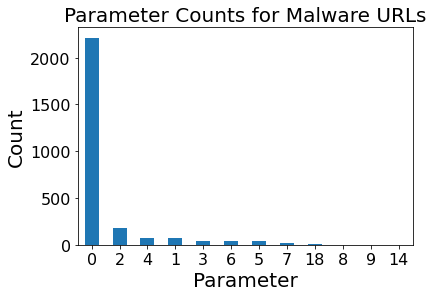

In [37]:
import matplotlib.pyplot as plt
# Graph counts
count = pd.value_counts(m_data['numParams'])
count.plot(kind='bar', fontsize=16)
plt.title("Parameter Counts for Malware URLs", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Parameter", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.show()

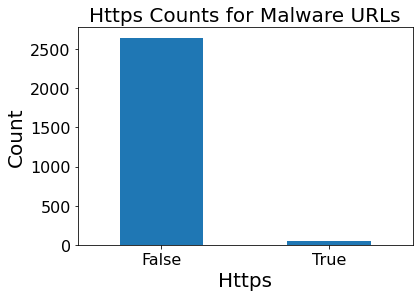

In [39]:
count = pd.value_counts(m_data['hasHttps'])
count.plot(kind='bar', fontsize=16)
plt.title("Https Counts for Malware URLs", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Https", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.show()

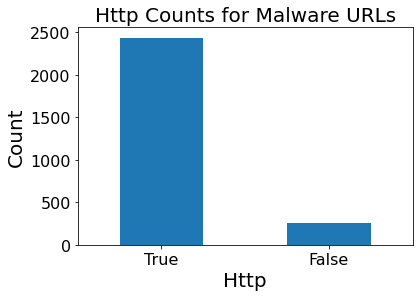

In [40]:
count = pd.value_counts(m_data['hasHttp'])
count.plot(kind='bar', fontsize=16)
plt.title("Http Counts for Malware URLs", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Http", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.show()